In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
# from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock, pdist, squareform
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
import pingouin as pg
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs,
    plot_subst_freqs, categorize_site_rates_robust_plus_invariant,
    color_mapping12,
)

In [2]:
coda = CodonAnnotation(1)

In [3]:
aa_freqs_total_dct = pd.read_json('./data/ref_aa_freqs_mean.json', orient='index')[0].to_dict()
aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

In [4]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()
spectrum_20A

subset clade mut_type  count  total_count  fraction parent_nt  \
0     all   20A     AtoC    305        18970  0.016078         A   
1     all   20A     AtoG   1778        18970  0.093727         A   
2     all   20A     AtoT    588        18970  0.030996         A   
3     all   20A     CtoA    384        18970  0.020242         C   
4     all   20A     CtoG    135        18970  0.007117         C   
5     all   20A     CtoT   7840        18970  0.413280         C   
6     all   20A     GtoA    878        18970  0.046284         G   
7     all   20A     GtoC    140        18970  0.007380         G   
8     all   20A     GtoT   2906        18970  0.153190         G   
9     all   20A     TtoA    639        18970  0.033685         T   
10    all   20A     TtoC   2912        18970  0.153510         T   
11    all   20A     TtoG    465        18970  0.024512         T   

    parent_nt_frac      rate  Mut  
0         0.289560  0.007540  A>C  
1         0.289560  0.043953  A>G  
2         0.289560  0.014536  A>T  
3         0.135130  0.020341  C>A  
4         0.135130  0.007151  C>G  
5         0.135130  0.415293  C>T  
6         0.064585  0.097310  G>A  
7         0.064585  0.015516  G>C  
8         0.064585  0.322075  G>T  
9         0.510720  0.008956  T>A  
10        0.510720  0.040812  T>C  
11        0.510720  0.006517  T>G

In [5]:
_clades_order = clades_spectra.drop_duplicates(subset='clade').set_index('clade')

_1 = {x:'Early clades' for x in _clades_order.loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in _clades_order.loc['21K':].index.unique()}

_clade2label = {**_1, **_2}
_clade2label

{'20A': 'Early clades',
 '20B': 'Early clades',
 '20C': 'Early clades',
 '20E': 'Early clades',
 '20G': 'Early clades',
 '20I': 'Early clades',
 '20J': 'Early clades',
 '21C': 'Early clades',
 '21I': 'Early clades',
 '21J': 'Early clades',
 '21K': 'Late clades\n(Omicron+)',
 '21L': 'Late clades\n(Omicron+)',
 '22A': 'Late clades\n(Omicron+)',
 '22B': 'Late clades\n(Omicron+)',
 '22C': 'Late clades\n(Omicron+)',
 '22D': 'Late clades\n(Omicron+)',
 '22E': 'Late clades\n(Omicron+)',
 '22F': 'Late clades\n(Omicron+)',
 '23A': 'Late clades\n(Omicron+)',
 '23B': 'Late clades\n(Omicron+)',
 '23C': 'Late clades\n(Omicron+)',
 '23D': 'Late clades\n(Omicron+)',
 '23F': 'Late clades\n(Omicron+)',
 '24A': 'Late clades\n(Omicron+)'}

In [6]:
obs_raw = pd.read_csv('data/bloom_etal/aggregated.csv').query('subset == "all" & exclude == False')
obs_raw['Mut'] = obs_raw['nt_mutation'].str[0] + '>' + obs_raw['nt_mutation'].str[-1]
obs = obs_raw.query('synonymous == False & noncoding == False').drop(['synonymous', 'noncoding', 'four_fold_degenerate'], axis=1)

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

protein    aa_mutation nt_mutation     codon_change  nt_site  \
0              ORF1ab         P5401L     C16466T          CCA>CTA    16466   
1                   M           I82T     T26767C          ATC>ACC    26767   
3              ORF1ab         P4715L     C14408T          CCT>CTT    14408   
4              ORF1ab         A6319V     C19220T          GCT>GTT    19220   
5              ORF1ab         I5658V     A17236G          ATA>GTA    17236   
...               ...            ...         ...              ...      ...   
1553870  ORF1a;ORF1ab  V4369A;V4369A     T13371C  GTC>GCC;GTC>GCC    13371   
1553871  ORF1a;ORF1ab  V4350A;V4350A     T13314C  GTA>GCA;GTA>GCA    13314   
1553874  ORF1a;ORF1ab  V3763F;V3763F     G11552T  GTT>TTT;GTT>TTT    11552   
1553875  ORF1a;ORF1ab  V3759G;V3759G     T11541G  GTT>GGT;GTT>GGT    11541   
1553876  ORF1a;ORF1ab  V4102A;V4102A     T12570C  GTA>GCA;GTA>GCA    12570   

        reference_nt clade_founder_nt  exclude  count  count_terminal  \
0                  C                C    False     70              37   
1                  T                T    False     58              18   
3                  C                C    False     52              26   
4                  C                C    False     50              15   
5                  A                A    False     48              24   
...              ...              ...      ...    ...             ...   
1553870            T                T    False      1               1   
1553871            T                T    False      1               1   
1553874            G                G    False      1               1   
1553875            T                T    False      1               0   
1553876            T                T    False      1               0   

         count_non_terminal  mean_log_size clade subset    codon  \
0                        33       0.708825   19A    all      CCA   
1                        40       1.237886   19A    all      ATC   
3                        26       0.678436   19A    all      CCT   
4                        35       1.097059   19A    all      GCT   
5                        24       0.581333   19A    all      ATA   
...                     ...            ...   ...    ...      ...   
1553870                   0       0.000000   24E    all  GTC;GTC   
1553871                   0       0.000000   24E    all  GTA;GTA   
1553874                   0       0.000000   24E    all  GTT;GTT   
1553875                   1       0.693147   24E    all  GTT;GTT   
1553876                   1       1.098612   24E    all  GTA;GTA   

        codon_position codon_site  Mut aa1 aa2  
0                    2       5401  C>T   P   L  
1                    2         82  T>C   I   T  
3                    2       4715  C>T   P   L  
4                    2       6319  C>T   A   V  
5                    1       5658  A>G   I   V  
...                ...        ...  ...  ..  ..  
1553870            2;2  4369;4369  T>C   V   A  
1553871            2;2  4350;4350  T>C   V   A  
1553874            1;1  3763;3763  G>T   V   F  
1553875            2;2  3759;3759  T>G   V   G  
1553876            2;2  4102;4102  T>C   V   A  

[440648 rows x 20 columns]

### Categorize sites by mutation rate

In [7]:
from typing import Union
from Bio.SeqRecord import SeqRecord

def read_genbank_ref(gb: Union[str, SeqRecord]):
    if isinstance(gb, str):
        genome = next(SeqIO.parse(gb, "genbank"))
    elif isinstance(gb, SeqRecord):
        genome = gb
    else:
        raise NotImplementedError

    ftypes = {"CDS", "rRNA", "tRNA"}
    full_nucls = set("ACGT")
    data = []
    df: pd.DataFrame = None
    gene_qualifier = None
    for ftr in genome.features:
        if ftr.type == "source":
            source = ftr.extract(genome)
            seq = str(source.seq)
            for pos, nuc in enumerate(seq):
                context = seq[pos - 1: pos + 2]
                if len(context) < 3 or len(set(context).difference(full_nucls)) != 0:
                    context = None
                if nuc not in full_nucls:
                    nuc = context = None
                data.append({"Pos": pos + 1, "Nuc": nuc, "Context": context})
            df = pd.DataFrame(data)
            df["Strand"] = 0
            continue
        elif gene_qualifier is None and ftr.type in ftypes:
            for qualifier in ["gene", "product", "protein_id"]:
                if qualifier in ftr.qualifiers:
                    gene_qualifier = qualifier
                    break
            if gene_qualifier is None:
                raise RuntimeError(f"Cannot find any expected qualifier of feature: {ftr}; with following qualifiers: {ftr.qualifiers}")

        for pos in list(ftr.location):
            df.at[pos, "Type"] = ftr.type
            df.at[pos, "Strand"] = ftr.location.strand
            if ftr.type in ftypes:
                df.at[pos, qualifier] = ftr.qualifiers[qualifier][0]

    # add codon features
    df["PosInGene"] = -1
    df["PosInCodon"] = -1
    for gene_name in df[(df.Type == "CDS") & (df.Strand == 1)][gene_qualifier].unique():
        gdf = df[df[gene_qualifier] == gene_name]
        seq = gdf.Nuc.values
        for pos_in_gene, pos in enumerate(gdf.index):
            pic = pos_in_gene % 3
            cdn = seq[pos_in_gene - pic: pos_in_gene - pic + 3]
            cdn = "".join(cdn) if len(set(cdn).difference(full_nucls)) == 0 else None
            df.at[pos, "Codon"] = cdn
            df.at[pos, "PosInGene"] = pos_in_gene + 1
            df.at[pos, "PosInCodon"] = pic + 1

    df["Strand"] = df["Strand"].astype(np.int8)
    df["PosInCodon"] = df["PosInCodon"].astype(np.int8)
    df["PosInGene"] = df["PosInGene"].astype(np.int32)
    return df


In [8]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
265      266   A     GAT       1  mat_peptide  ORF1ab          1           1   
266      267   T     ATG       1  mat_peptide  ORF1ab          2           2   
267      268   G     TGG       1  mat_peptide  ORF1ab          3           3   
268      269   G     GGA       1  mat_peptide  ORF1ab          4           1   
269      270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29669  29670   C     ACA       1          CDS   ORF10        113           2   
29670  29671   A     CAT       1          CDS   ORF10        114           3   
29671  29672   T     ATA       1          CDS   ORF10        115           1   
29672  29673   A     TAG       1          CDS   ORF10        116           2   
29673  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  
265     ATG  
266     ATG  
267     ATG  
268     GAG  
269     GAG  
...     ...  
29669   ACA  
29670   ACA  
29671   TAG  
29672   TAG  
29673   TAG  

[29260 rows x 9 columns]

In [9]:
_cnt1 = obs_raw.groupby(['clade', 'nt_site'])['count'].sum().rename('MutCountTotal').reset_index()
_cnt2 = obs.groupby(['clade', 'nt_site'])['count'].sum().rename('MutCountNonsyn').reset_index()

ref_sites_df_clades = ref_sites_df.rename(columns={'Pos':'nt_site'}).merge(_cnt1, 'left')
ref_sites_df_clades = ref_sites_df_clades.merge(_cnt2, 'left')
ref_sites_df_clades.fillna({'MutCountNonsyn': 0, 'MutCountTotal': 0}, inplace=True)
# ref_sites_df_clades = ref_sites_df_clades.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), how='left')
ref_sites_df_clades['AA'] = ref_sites_df_clades['Codon'].apply(coda.translate_codon).map(amino_acid_codes)

data = []
for clade in obs_raw.clade.unique():
    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df['MutCountTotal'], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df['rate_cat'] = categories

    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df['MutCountNonsyn'], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df['rate_cat_ns'] = categories

    data.append(cur_ref_sites_df)

ref_sites_df_clades_cat = pd.concat(data, axis=0)
ref_sites_df_clades_cat.to_csv('./data/ref_sites_rates_categories_clades.csv.gz', index=False)
ref_sites_df_clades_cat

nt_site Nuc Context  Strand         Type    gene  PosInGene  \
107         274   C     GCC       1  mat_peptide  ORF1ab          9   
189         278   G     TGT       1  mat_peptide  ORF1ab         13   
231         280   C     TCC       1  mat_peptide  ORF1ab         15   
281         282   C     CCT       1  mat_peptide  ORF1ab         17   
323         284   G     TGG       1  mat_peptide  ORF1ab         19   
...         ...  ..     ...     ...          ...     ...        ...   
481010    29667   T     CTC       1          CDS   ORF10        110   
481039    29668   C     TCA       1          CDS   ORF10        111   
481091    29670   C     ACA       1          CDS   ORF10        113   
481112    29671   A     CAT       1          CDS   ORF10        114   
481128    29672   T     ATA       1          CDS   ORF10        115   

        PosInCodon Codon clade  MutCountTotal  MutCountNonsyn   AA  rate_cat  \
107              3   AGC   19A            2.0             0.0  Ser         3   
189              1   GTC   19A            1.0             1.0  Val         2   
231              3   GTC   19A            1.0             0.0  Val         2   
281              2   CCT   19A            1.0             1.0  Pro         2   
323              1   GGT   19A            2.0             2.0  Gly         3   
...            ...   ...   ...            ...             ...  ...       ...   
481010           2   CTC   24E            1.0             1.0  Leu         1   
481039           3   CTC   24E            5.0             0.0  Leu         4   
481091           2   ACA   24E            3.0             3.0  Thr         3   
481112           3   ACA   24E            2.0             0.0  Thr         3   
481128           1   TAG   24E            2.0             0.0    *         3   

        rate_cat_ns  
107               0  
189               2  
231               0  
281               2  
323               3  
...             ...  
481010            1  
481039            0  
481091            4  
481112            0  
481128            0  

[480459 rows x 15 columns]

In [10]:
obs['aa_site'] = obs['aa_mutation'].apply(lambda x: int(x.split(';')[0][1:-1]))

ref_sites_df['MutCountTotal'] = ref_sites_df['Pos'].map(obs_raw.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df['MutCountNonsyn'] = ref_sites_df['Pos'].map(obs.groupby(['nt_site'])['count'].sum()).fillna(0.)

ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position', 'aa_site']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')


assert ref_sites_df.Codon.isna().sum() == 0

ref_sites_df['AA'] = ref_sites_df['Codon'].apply(coda.translate_codon).map(amino_acid_codes)
ref_sites_df['nt_site'] = ref_sites_df['Pos']

ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
0        266   A     GAT       1  mat_peptide  ORF1ab          1           1   
1        267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2        268   G     TGG       1  mat_peptide  ORF1ab          3           3   
3        269   G     GGA       1  mat_peptide  ORF1ab          4           1   
4        270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29255  29670   C     ACA       1          CDS   ORF10        113           2   
29256  29671   A     CAT       1          CDS   ORF10        114           3   
29257  29672   T     ATA       1          CDS   ORF10        115           1   
29258  29673   A     TAG       1          CDS   ORF10        116           2   
29259  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site  \
0       ATG            0.0             0.0      266            NaN      NaN   
1       ATG            2.0             2.0      267            2;2      1.0   
2       ATG            1.0             1.0      268            3;3      1.0   
3       GAG          239.0           239.0      269            1;1      2.0   
4       GAG          154.0           154.0      270            2;2      2.0   
...     ...            ...             ...      ...            ...      ...   
29255   ACA          687.0           687.0    29670              2     38.0   
29256   ACA          114.0             1.0    29671              3     38.0   
29257   TAG           57.0             0.0    29672            NaN      NaN   
29258   TAG           29.0             0.0    29673            NaN      NaN   
29259   TAG          177.0             0.0    29674            NaN      NaN   

        AA  
0      Met  
1      Met  
2      Met  
3      Glu  
4      Glu  
...    ...  
29255  Thr  
29256  Thr  
29257    *  
29258    *  
29259    *  

[29260 rows x 15 columns]

In [11]:
ref_sites_df.MutCountTotal.sum(), obs_raw['count'].sum()

(np.float64(5611539.0), np.int64(5635999))

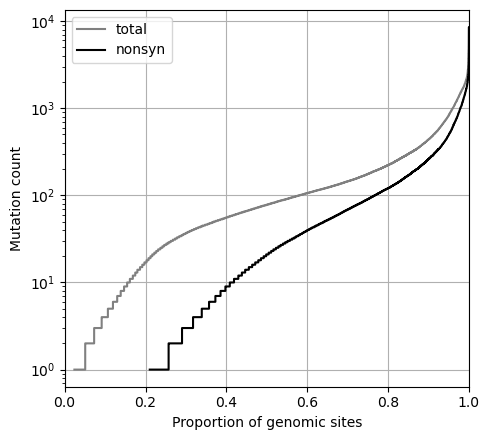

In [89]:
plt.figure(figsize=(5, 4.5))
sns.ecdfplot(ref_sites_df, y='MutCountTotal', log_scale=(False, True), color='gray', label='total')
sns.ecdfplot(ref_sites_df, y='MutCountNonsyn', log_scale=(False, True), color='k', label='nonsyn')
plt.grid(True)
plt.ylabel('Mutation count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
plt.legend(loc='upper left')
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

Summary: 705 zero sites, 28269 gamma sites, 286 hotspots.


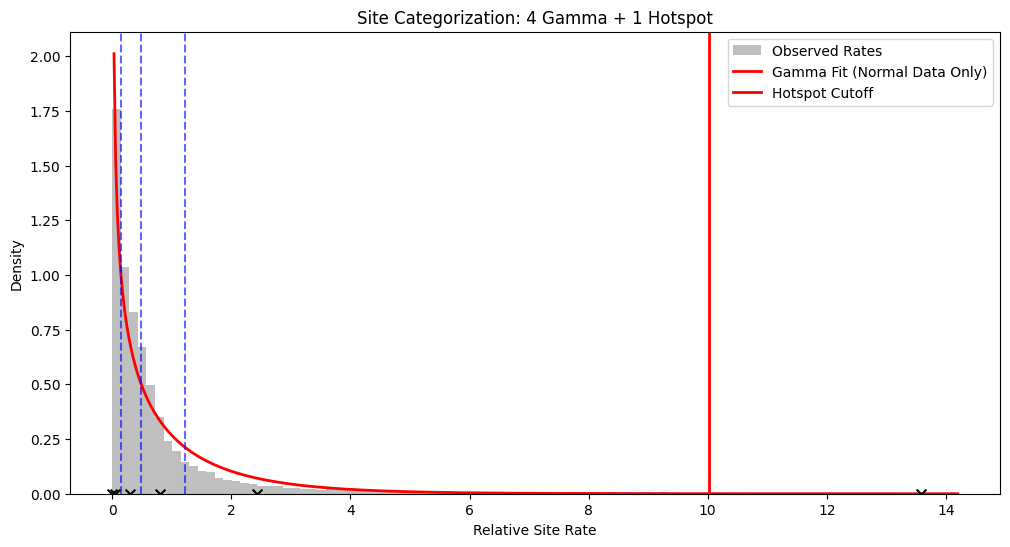

In [12]:
categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
    ref_sites_df['MutCountTotal'], 6, 99, plot=True)

ref_sites_df['rate_cat'] = categories

Summary: 6159 zero sites, 22870 gamma sites, 231 hotspots.


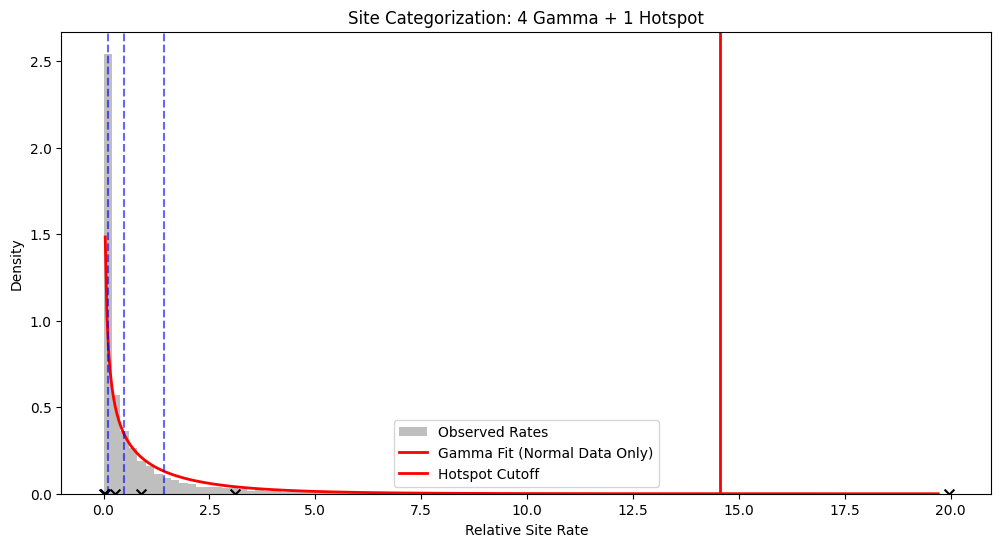

In [13]:
categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
    ref_sites_df['MutCountNonsyn'], 6, 99, plot=True)

ref_sites_df['rate_cat_ns'] = categories

In [15]:
ref_sites_df.to_csv('./data/ref_annot.csv', index=False)

ref_sites_df[['Pos', 'MutCountTotal', 'MutCountNonsyn', 'rate_cat', 'rate_cat_ns']]\
    .to_csv('data/ref_sites_rates_cat5.csv', index=False, float_format='%g')

### Explore Cat-specific spectra

In [14]:
def get_syn_muts(row: pd.Series):
    syn_muts = []
    if row.PosInCodon == 2 or len(row.syn_codons) == 0:
        return []
    elif row.PosInCodon == 1 or row.PosInCodon == 3:
        pic = row.PosInCodon - 1
        for cdn in row.syn_codons:
            mut = f"{row.Codon[pic]}>{cdn[pic]}"
            syn_muts.append(mut)
    return syn_muts

def get_nonsyn_muts(row: pd.Series):
    '''run after syn_muts derived'''
    nonsyn_muts = []
    assert 'syn_muts' in row.index
    nuc1 = row.Nuc
    for nuc2 in 'ACGT':
        mut = f"{nuc1}>{nuc2}"
        if nuc1 == nuc2 or mut in row.syn_muts:
            continue
        nonsyn_muts.append(mut)
    return nonsyn_muts

In [15]:
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
0        266   A     GAT       1  mat_peptide  ORF1ab          1           1   
1        267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2        268   G     TGG       1  mat_peptide  ORF1ab          3           3   
3        269   G     GGA       1  mat_peptide  ORF1ab          4           1   
4        270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29255  29670   C     ACA       1          CDS   ORF10        113           2   
29256  29671   A     CAT       1          CDS   ORF10        114           3   
29257  29672   T     ATA       1          CDS   ORF10        115           1   
29258  29673   A     TAG       1          CDS   ORF10        116           2   
29259  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site  \
0       ATG            0.0             0.0      266            NaN      NaN   
1       ATG            2.0             2.0      267            2;2      1.0   
2       ATG            1.0             1.0      268            3;3      1.0   
3       GAG          239.0           239.0      269            1;1      2.0   
4       GAG          154.0           154.0      270            2;2      2.0   
...     ...            ...             ...      ...            ...      ...   
29255   ACA          687.0           687.0    29670              2     38.0   
29256   ACA          114.0             1.0    29671              3     38.0   
29257   TAG           57.0             0.0    29672            NaN      NaN   
29258   TAG           29.0             0.0    29673            NaN      NaN   
29259   TAG          177.0             0.0    29674            NaN      NaN   

        AA  rate_cat  rate_cat_ns  
0      Met         0            0  
1      Met         1            1  
2      Met         1            1  
3      Glu         4            4  
4      Glu         3            3  
...    ...       ...          ...  
29255  Thr         4            4  
29256  Thr         3            1  
29257    *         2            0  
29258    *         2            0  
29259    *         3            0  

[29260 rows x 17 columns]

In [17]:
ref_sites_df['fourfold'] = ref_sites_df.Codon.apply(coda.is_fourfold)
ref_sites_df['num_of_syn_codons'] = ref_sites_df.apply(lambda x: len(coda.get_syn_codons(x['Codon'], x['PosInCodon']-1)), axis=1)
ref_sites_df['syn_codons'] = ref_sites_df.apply(lambda x: (coda.get_syn_codons(x['Codon'], x['PosInCodon']-1)), axis=1)
ref_sites_df['syn_muts'] = ref_sites_df.apply(get_syn_muts, axis=1)
ref_sites_df.query('PosInCodon == 3 & fourfold & num_of_syn_codons < 3')

Empty DataFrame
Columns: [Pos, Nuc, Context, Strand, Type, gene, PosInGene, PosInCodon, Codon, MutCountTotal, MutCountNonsyn, nt_site, codon_position, aa_site, AA, rate_cat, rate_cat_ns, fourfold, num_of_syn_codons, syn_codons, syn_muts]
Index: []

[0 rows x 21 columns]

In [18]:
ref_sites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29260 entries, 0 to 29259
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pos                29260 non-null  int64  
 1   Nuc                29260 non-null  object 
 2   Context            29260 non-null  object 
 3   Strand             29260 non-null  int8   
 4   Type               29260 non-null  object 
 5   gene               29260 non-null  object 
 6   PosInGene          29260 non-null  int32  
 7   PosInCodon         29260 non-null  int8   
 8   Codon              29260 non-null  object 
 9   MutCountTotal      29260 non-null  float64
 10  MutCountNonsyn     29260 non-null  float64
 11  nt_site            29260 non-null  int64  
 12  codon_position     23101 non-null  object 
 13  aa_site            23101 non-null  float64
 14  AA                 29260 non-null  object 
 15  rate_cat           29260 non-null  int64  
 16  rate_cat_ns        292

In [19]:
obs_syn = obs_raw.query('synonymous & four_fold_degenerate')
obs_annot = obs_syn.merge(ref_sites_df[['nt_site', 'rate_cat']])
# obs_annot = obs_annot.query('rate_cat >= 3')
obs_annot

protein    aa_mutation nt_mutation     codon_change  synonymous  \
0       ORF1a;ORF1ab  V3689V;V3689V     A11332G  GTA>GTG;GTA>GTG        True   
1                  S         V1264V     G25354C          GTG>GTC        True   
2              ORF7a           G38G     A27507C          GGA>GGC        True   
3       ORF1a;ORF1ab  T1773T;T1773T      A5584G  ACA>ACG;ACA>ACG        True   
4       ORF1a;ORF1ab    S549S;S549S      C1912T  TCC>TCT;TCC>TCT        True   
...              ...            ...         ...              ...         ...   
142058  ORF1a;ORF1ab    V424V;V424V      T1537C  GTT>GTC;GTT>GTC        True   
142059  ORF1a;ORF1ab  V4181V;V4181V     A12808G  GTA>GTG;GTA>GTG        True   
142060  ORF1a;ORF1ab    V414V;V414V      T1507C  GTT>GTC;GTT>GTC        True   
142061  ORF1a;ORF1ab  V4310V;V4310V     T13195G  GTT>GTG;GTT>GTG        True   
142062  ORF1a;ORF1ab  V4260V;V4260V     G13045A  GTG>GTA;GTG>GTA        True   

        noncoding  nt_site reference_nt clade_founder_nt  exclude  ...  \
0           False    11332            A                A    False  ...   
1           False    25354            G                G    False  ...   
2           False    27507            A                A    False  ...   
3           False     5584            A                A    False  ...   
4           False     1912            C                C    False  ...   
...           ...      ...          ...              ...      ...  ...   
142058      False     1537            T                T    False  ...   
142059      False    12808            A                A    False  ...   
142060      False     1507            T                T    False  ...   
142061      False    13195            T                T    False  ...   
142062      False    13045            G                G    False  ...   

        count_non_terminal  mean_log_size  clade  subset    codon  \
0                       26       1.066247    19A     all  GTA;GTA   
1                        4       0.198628    19A     all      GTG   
2                        6       0.421588    19A     all      GGA   
3                        2       0.126027    19A     all  ACA;ACA   
4                        3       0.562040    19A     all  TCC;TCC   
...                    ...            ...    ...     ...      ...   
142058                   1       1.098612    24E     all  GTT;GTT   
142059                   0       0.000000    24E     all  GTA;GTA   
142060                   0       0.000000    24E     all  GTT;GTT   
142061                   1       0.693147    24E     all  GTT;GTT   
142062                   0       0.000000    24E     all  GTG;GTG   

       codon_position codon_site four_fold_degenerate  Mut  rate_cat  
0                 3;3  3689;3689                 True  A>G         4  
1                   3       1264                 True  G>C         4  
2                   3         38                 True  A>C         4  
3                 3;3  1773;1773                 True  A>G         3  
4                 3;3    549;549                 True  C>T         5  
...               ...        ...                  ...  ...       ...  
142058            3;3    424;424                 True  T>C         4  
142059            3;3  4181;4181                 True  A>G         2  
142060            3;3    414;414                 True  T>C         3  
142061            3;3  4310;4310                 True  T>G         3  
142062            3;3  4260;4260                 True  G>A         4  

[142063 rows x 22 columns]

In [20]:
cat_obs = obs_annot.groupby(['clade', 'Mut'])['count'].sum().unstack()
cat_obs = cat_obs.div(cat_obs.sum(1), axis=0).fillna(0)
cat_obs.head()

Mut         A>C       A>G       A>T       C>A       C>G       C>T       G>A  \
clade                                                                         
19A    0.027059  0.131765  0.039412  0.018235  0.004118  0.358235  0.040000   
20A    0.016078  0.093727  0.030996  0.020242  0.007116  0.413284  0.046284   
20B    0.011875  0.091271  0.030776  0.019709  0.005658  0.419423  0.042589   
20C    0.011945  0.094015  0.028099  0.021848  0.002971  0.405892  0.049638   
20E    0.013897  0.104546  0.028713  0.020707  0.011136  0.434014  0.041045   

Mut         G>C       G>T       T>A       T>C       T>G  
clade                                                    
19A    0.020000  0.128235  0.037647  0.161765  0.033529  
20A    0.007380  0.153189  0.033685  0.153506  0.024512  
20B    0.006466  0.158045  0.032455  0.153320  0.028413  
20C    0.006375  0.141796  0.038559  0.146871  0.051990  
20E    0.004509  0.122860  0.038008  0.156451  0.024112

In [21]:
# SYN4f
nuc_cnt = ref_sites_df.query('PosInCodon == 3 & fourfold').syn_muts.explode().value_counts()

# SYN
# nuc_cnt = ref_sites_df.syn_muts.explode().value_counts()

nuc_cnt = nuc_cnt / nuc_cnt.sum() #* 3
nuc_cnt

syn_muts
T>A    0.149668
T>C    0.149668
T>G    0.149668
A>T    0.100049
A>G    0.100049
A>C    0.100049
C>A    0.045734
C>T    0.045734
C>G    0.045734
G>A    0.037882
G>C    0.037882
G>T    0.037882
Name: count, dtype: float64

In [22]:
nuc_cnt.sum(), cat_obs.sum(axis=1).unique()

(np.float64(0.9999999999999999), array([1., 1., 1., 1.]))

In [29]:
cat_spectra = cat_obs / nuc_cnt
# cat_spectra = cat_spectra.div(cat_spectra.sum(1), axis=0)
cat_spectra.tail()

A>C       A>G       A>T       C>A       C>G       C>T       G>A  \
clade                                                                         
23F    0.138637  1.203418  0.366533  0.649497  0.080322  8.489165  1.601668   
24A    0.101686  1.006608  0.387472  0.679008  0.113915  9.295321  1.433737   
24B    0.096079  0.984084  0.294061  0.579598  0.082800  9.311780  1.407146   
24C    0.105754  1.011446  0.263030  0.818621  0.100845  9.402278  1.482439   
24E    0.127865  1.029422  0.290405  0.606848  0.075856  9.183315  1.631238   

            G>C       G>T       T>A       T>C       T>G  
clade                                                    
23F    0.177220  1.860811  0.259827  1.391387  0.149803  
24A    0.166764  1.921034  0.285326  1.273962  0.148282  
24B    0.199922  2.076116  0.282205  1.288412  0.212140  
24C    0.164715  2.055362  0.266460  1.238044  0.163139  
24E    0.160262  2.237944  0.281050  1.270518  0.127486

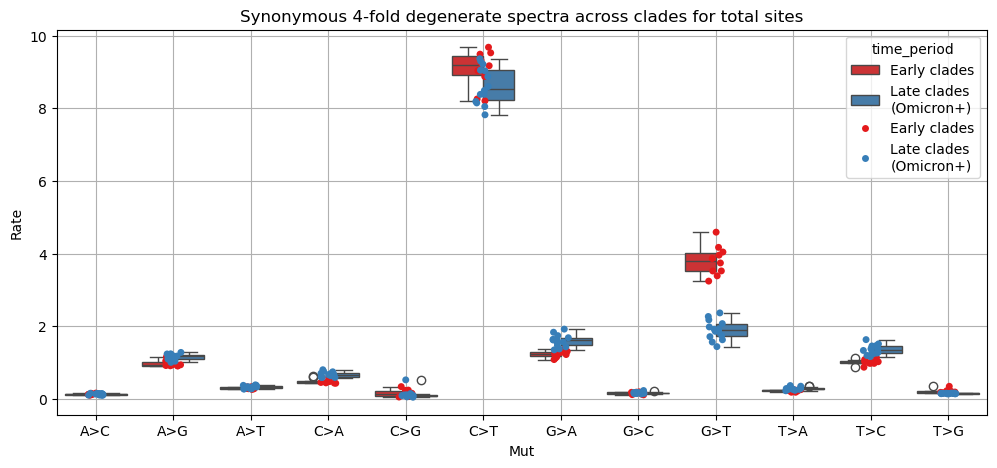

In [23]:
plt.figure(figsize=(12, 5))
_ = cat_spectra.melt(ignore_index=False, value_name='Rate', var_name='Mut').reset_index()
_['time_period'] = _.clade.map(_clade2label)
sns.boxplot(_, x='Mut', y='Rate', hue='time_period', palette='Set1')
sns.stripplot(_, x='Mut', y='Rate', hue='time_period', palette='Set1')
plt.title('Synonymous 4-fold degenerate spectra across clades for total sites')
plt.grid(True)

In [30]:
cat_obs = obs_annot.groupby(['clade', 'rate_cat', 'Mut'])['count'].sum().unstack()
# cat_obs = cat_obs[cat_obs.sum(1) > 100]
cat_obs = cat_obs.div(cat_obs.sum(1), axis=0).fillna(0)
cat_obs

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2         0.033149  0.237569  0.077348  0.000000  0.000000  0.011050   
      3         0.052885  0.250000  0.098558  0.012019  0.000000  0.062500   
      4         0.020666  0.088404  0.013777  0.026406  0.003444  0.454650   
      5         0.000000  0.000000  0.000000  0.012987  0.017316  0.800866   
...                  ...       ...       ...       ...       ...       ...   
24E   1         0.000000  0.200000  0.000000  0.000000  0.000000  0.000000   
      2         0.027273  0.245455  0.025000  0.000000  0.000000  0.004545   
      3         0.034121  0.242345  0.068241  0.005249  0.000875  0.052493   
      4         0.003532  0.038852  0.019868  0.045916  0.004857  0.558499   
      5         0.000000  0.001318  0.000000  0.023715  0.005270  0.803689   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   1         0.000000  0.000000  0.000000  1.000000  0.000000  0.000000  
      2         0.016575  0.000000  0.011050  0.038674  0.480663  0.093923  
      3         0.007212  0.002404  0.026442  0.088942  0.319712  0.079327  
      4         0.065442  0.027555  0.210103  0.019518  0.061998  0.008037  
      5         0.021645  0.038961  0.095238  0.008658  0.004329  0.000000  
...                  ...       ...       ...       ...       ...       ...  
24E   1         0.000000  0.000000  0.000000  0.200000  0.600000  0.000000  
      2         0.002273  0.000000  0.002273  0.061364  0.584091  0.047727  
      3         0.025372  0.003500  0.020122  0.083990  0.424322  0.039370  
      4         0.106402  0.005740  0.138631  0.017219  0.051214  0.009272  
      5         0.018445  0.014493  0.069829  0.040843  0.021080  0.001318  

[149 rows x 12 columns]

Text(0, 0.5, 'SYN Mutation count in clade')

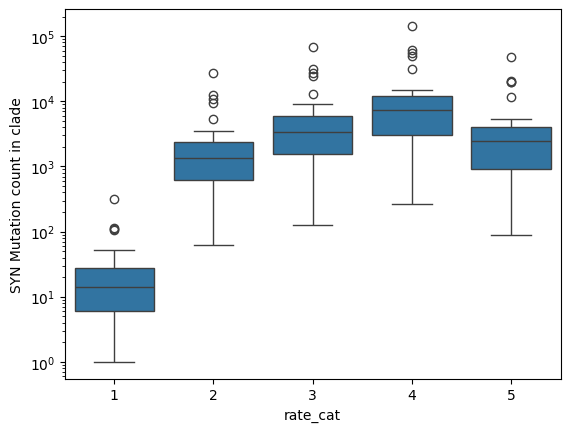

In [31]:
_ = obs_annot.groupby(['clade', 'rate_cat'])['count'].sum().reset_index()
sns.boxplot(_, x='rate_cat', y='count')
plt.yscale('log')
plt.ylabel('SYN Mutation count in clade')

In [32]:
_ = obs_annot.groupby([ 'rate_cat'])['count'].sum().reset_index()
_

rate_cat   count
0         1    1029
1         2   96434
2         3  243183
3         4  491952
4         5  170245

In [33]:
# SYN4f
nuc_cnt = ref_sites_df.query('PosInCodon == 3 & fourfold').set_index('rate_cat')\
    .syn_muts.explode(ignore_index=False)\
        .dropna().reset_index().groupby(['rate_cat', 'syn_muts']).size().unstack()
# SYN
# nuc_cnt = ref_sites_df.set_index('rate_cat').syn_muts.explode(ignore_index=False)\
#     .dropna().reset_index().groupby(['rate_cat', 'syn_muts']).size().unstack()

nuc_cnt = nuc_cnt.div(nuc_cnt.sum(1), axis=0).fillna(0)
nuc_cnt

syn_muts       A>C       A>G       A>T       C>A       C>G       C>T  \
rate_cat                                                               
0         0.154762  0.154762  0.154762  0.011905  0.011905  0.011905   
1         0.118280  0.118280  0.118280  0.030824  0.030824  0.030824   
2         0.106072  0.106072  0.106072  0.007803  0.007803  0.007803   
3         0.121085  0.121085  0.121085  0.016129  0.016129  0.016129   
4         0.040998  0.040998  0.040998  0.165330  0.165330  0.165330   
5         0.000000  0.000000  0.000000  0.285714  0.285714  0.285714   

syn_muts       G>A       G>C       G>T       T>A       T>C       T>G  
rate_cat                                                              
0         0.047619  0.047619  0.047619  0.119048  0.119048  0.119048  
1         0.059498  0.059498  0.059498  0.124731  0.124731  0.124731  
2         0.016825  0.016825  0.016825  0.202634  0.202634  0.202634  
3         0.023609  0.023609  0.023609  0.172511  0.172511  0.172511  
4         0.089127  0.089127  0.089127  0.037879  0.037879  0.037879  
5         0.041667  0.041667  0.041667  0.005952  0.005952  0.005952

In [34]:
cat_spectra = cat_obs / nuc_cnt
# cat_spectra = cat_spectra.div(cat_spectra.sum(1), axis=0)
cat_spectra

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2         0.312517  2.239703  0.729206  0.000000  0.000000  1.416091   
      3         0.436757  2.064672  0.813957  0.745192  0.000000  3.875000   
      4         0.504068  2.156292  0.336046  0.159720  0.020833  2.749957   
      5              NaN       NaN       NaN  0.045455  0.060606  2.803030   
...                  ...       ...       ...       ...       ...       ...   
24E   1         0.000000  1.690909  0.000000  0.000000  0.000000  0.000000   
      2         0.257116  2.314044  0.235690  0.000000  0.000000  0.582528   
      3         0.281792  2.001449  0.563585  0.325459  0.054243  3.254593   
      4         0.086150  0.947653  0.484595  0.277724  0.029375  3.378090   
      5              NaN       inf       NaN  0.083004  0.018445  2.812912   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   1         0.000000  0.000000  0.000000  8.017241  0.000000  0.000000  
      2         0.985107  0.000000  0.656738  0.190857  2.372080  0.463510  
      3         0.305455  0.101818  1.120002  0.515576  1.853287  0.459838  
      4         0.734259  0.309162  2.357359  0.515270  1.636739  0.212170  
      5         0.519481  0.935065  2.285714  1.454545  0.727273  0.000000  
...                  ...       ...       ...       ...       ...       ...  
24E   1         0.000000  0.000000  0.000000  1.603448  4.810345  0.000000  
      2         0.135079  0.000000  0.135079  0.302831  2.882499  0.235535  
      3         1.074660  0.148229  0.852317  0.486866  2.459687  0.228218  
      4         1.193828  0.064397  1.555444  0.454570  1.352053  0.244768  
      5         0.442688  0.347826  1.675889  6.861660  3.541502  0.221344  

[149 rows x 12 columns]

In [35]:
cat_spectra.to_csv('./data/syn4f_spectra_by_rate_cat.csv')

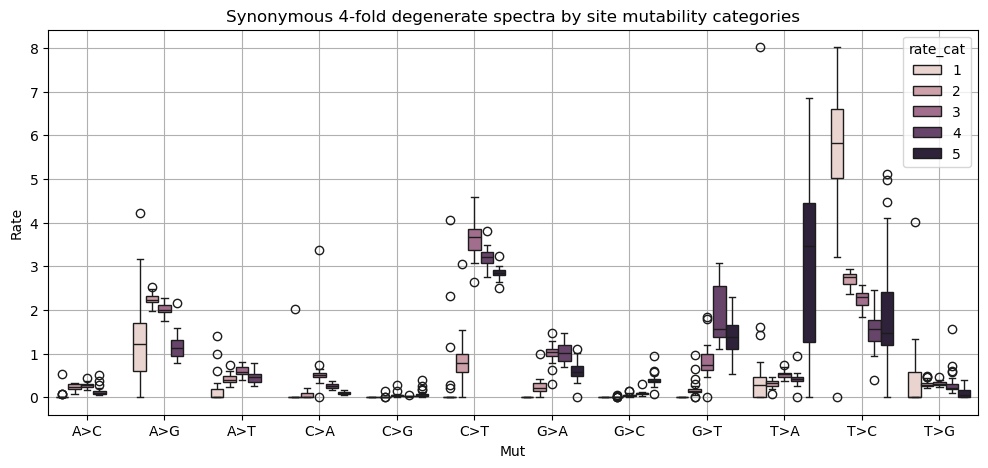

In [30]:
plt.figure(figsize=(12, 5))
_ = cat_spectra.melt(ignore_index=False, value_name='Rate').reset_index()
_['time_period'] = _.clade.map(_clade2label)
sns.boxplot(_.query('rate_cat >= 0 & rate_cat <= 5'), x='Mut', y='Rate', hue='rate_cat')
plt.title('Synonymous 4-fold degenerate spectra by site mutability categories')
plt.grid()

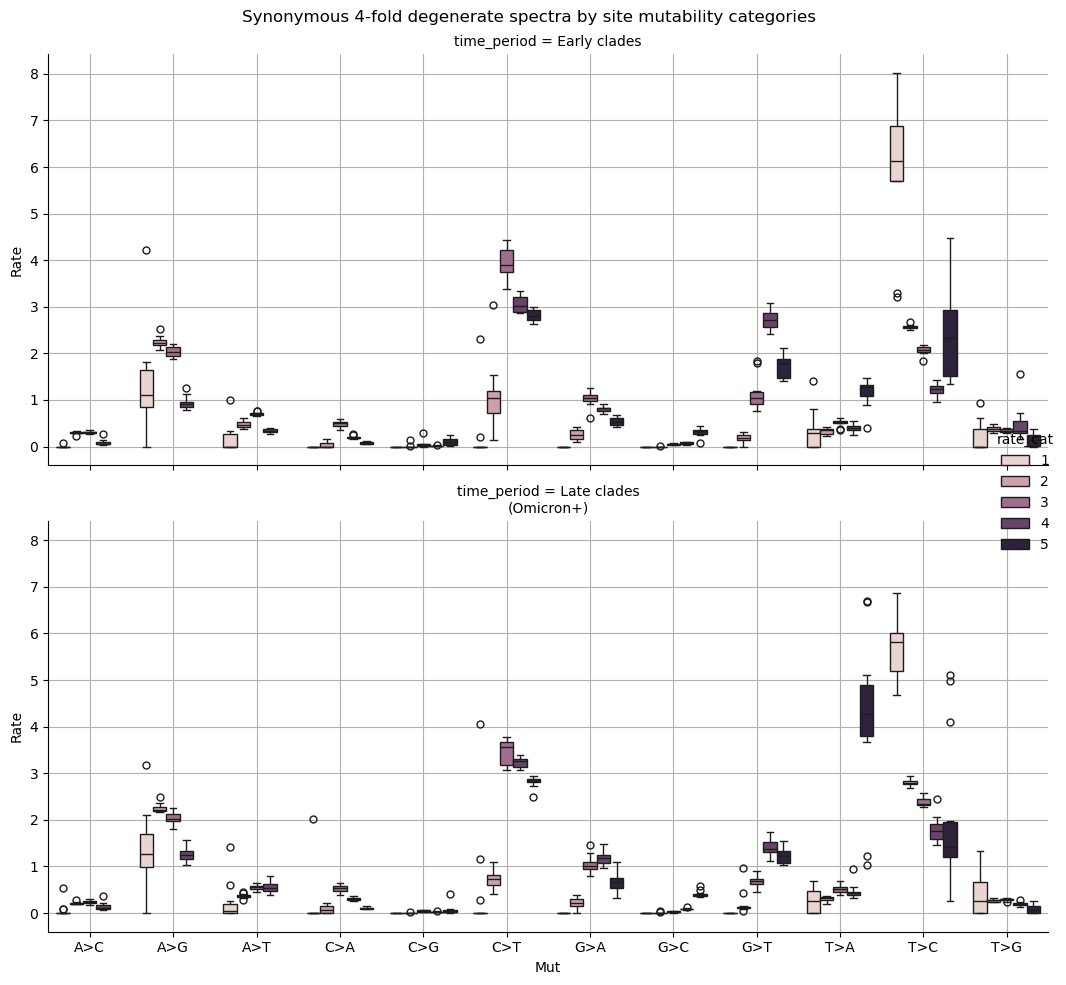

In [31]:
_ = cat_spectra.melt(ignore_index=False, value_name='Rate').reset_index()
_['time_period'] = _.clade.map(_clade2label)
g = sns.catplot(_.query('rate_cat >= 1 & rate_cat <= 5'), 
            x='Mut', y='Rate', hue='rate_cat', row='time_period',
            kind='box', aspect=2
)
g.fig.suptitle('Synonymous 4-fold degenerate spectra by site mutability categories')
for ax in g.axes.flat:
    ax.grid()
plt.tight_layout()

#### Non-syn spectrum

In [35]:
obs_ns_annot = obs.merge(ref_sites_df_clades_cat[['clade', 'rate_cat', 'nt_site']], 'left')

obs_ns_freqs = obs_ns_annot.groupby(['clade', 'rate_cat', 'Mut'])['count'].sum().unstack()
obs_ns_freqs = obs_ns_freqs.div(obs_ns_freqs.sum(1), axis=0).fillna(0)
obs_ns_freqs

/tmp/ipykernel_8332/2925179197.py:4: Pandas4Warning: Starting with pandas version 4.0 all arguments of sum will be keyword-only.
  obs_ns_freqs = obs_ns_freqs.div(obs_ns_freqs.sum(1), axis=0).fillna(0)


Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   2         0.040375  0.161501  0.041599  0.028548  0.006525  0.238989   
      3         0.018489  0.096463  0.019293  0.032958  0.006431  0.394695   
      4         0.018386  0.047534  0.013453  0.038117  0.008520  0.521525   
      5         0.018268  0.121525  0.000000  0.039714  0.051628  0.355044   
20A   1         0.066509  0.261041  0.060726  0.024185  0.006572  0.088591   
...                  ...       ...       ...       ...       ...       ...   
24C   5         0.001269  0.098985  0.000000  0.081218  0.020305  0.555838   
24E   1         0.040359  0.228700  0.050017  0.030700  0.006899  0.158675   
      3         0.020887  0.137053  0.020315  0.040343  0.007439  0.311874   
      4         0.004528  0.040966  0.010565  0.048728  0.007546  0.642518   
      5         0.000000  0.060984  0.000693  0.062370  0.013860  0.571726   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   2         0.121533  0.024878  0.190865  0.023246  0.088499  0.033442  
      3         0.090836  0.020900  0.248392  0.013666  0.041801  0.016077  
      4         0.059641  0.026906  0.201345  0.007623  0.036323  0.020628  
      5         0.069897  0.024623  0.130262  0.000794  0.114376  0.073868  
20A   1         0.125657  0.015247  0.086751  0.041272  0.173239  0.050210  
...                  ...       ...       ...       ...       ...       ...  
24C   5         0.067259  0.025381  0.142132  0.000000  0.001269  0.006345  
24E   1         0.166954  0.014488  0.126595  0.019317  0.127630  0.029665  
      3         0.157082  0.023748  0.177396  0.013734  0.077539  0.012589  
      4         0.060155  0.021345  0.130229  0.006684  0.016602  0.010134  
      5         0.024255  0.041580  0.204435  0.000693  0.013860  0.005544  

[142 rows x 12 columns]

In [36]:
ref_sites_df_clades_cat['num_of_syn_codons'] = ref_sites_df_clades_cat.apply(lambda x: len(coda.get_syn_codons(x['Codon'], x['PosInCodon']-1)), axis=1)
ref_sites_df_clades_cat['syn_codons'] = ref_sites_df_clades_cat.apply(lambda x: (coda.get_syn_codons(x['Codon'], x['PosInCodon']-1)), axis=1)
ref_sites_df_clades_cat['syn_muts'] = ref_sites_df_clades_cat.apply(get_syn_muts, axis=1)
ref_sites_df_clades_cat['nonsyn_muts'] = ref_sites_df_clades_cat.apply(get_nonsyn_muts, axis=1)

In [37]:
exp_ns_freq = ref_sites_df_clades_cat.set_index(['clade', 'rate_cat'])\
    .nonsyn_muts.explode(ignore_index=False).dropna().reset_index()\
        .groupby(['clade', 'rate_cat', 'nonsyn_muts']).size().unstack()
exp_ns_freq = exp_ns_freq.div(exp_ns_freq.sum(1), axis=0)
exp_ns_freq

/tmp/ipykernel_8332/215783699.py:4: Pandas4Warning: Starting with pandas version 4.0 all arguments of sum will be keyword-only.
  exp_ns_freq = exp_ns_freq.div(exp_ns_freq.sum(1), axis=0)


nonsyn_muts          A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   2         0.083568  0.071404  0.085257  0.101363  0.104516  0.074558   
      3         0.041807  0.037584  0.043074  0.176520  0.183277  0.119510   
      4         0.022505  0.017123  0.022505  0.233366  0.242172  0.157045   
      5         0.054795  0.047945  0.054795  0.178082  0.184932  0.116438   
20A   1         0.131431  0.112258  0.134431  0.034394  0.035419  0.028321   
...                  ...       ...       ...       ...       ...       ...   
24C   5         0.015464  0.015464  0.015464  0.309278  0.340206  0.211340   
24E   1         0.106502  0.087600  0.108602  0.067734  0.069572  0.051020   
      3         0.062623  0.051639  0.064262  0.125902  0.129180  0.090164   
      4         0.015630  0.013270  0.016219  0.265703  0.278089  0.171926   
      5         0.007812  0.011719  0.011719  0.304688  0.328125  0.187500   

nonsyn_muts          G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   2         0.078725  0.098097  0.098097  0.076247  0.049330  0.078838  
      3         0.082770  0.108108  0.108108  0.037162  0.024071  0.038007  
      4         0.069961  0.090509  0.090509  0.020059  0.013209  0.021037  
      5         0.054795  0.068493  0.068493  0.068493  0.034247  0.068493  
20A   1         0.057373  0.063666  0.063666  0.124332  0.085108  0.129601  
...                  ...       ...       ...       ...       ...       ...  
24C   5         0.020619  0.030928  0.030928  0.005155       NaN  0.005155  
24E   1         0.069135  0.087162  0.087162  0.098626  0.062834  0.104052  
      3         0.080328  0.103607  0.103607  0.071803  0.041967  0.074918  
      4         0.050428  0.065762  0.065762  0.022412  0.011796  0.023002  
      5         0.035156  0.046875  0.046875  0.007812  0.003906  0.007812  

[142 rows x 12 columns]

In [38]:
cat_spectra_ns = obs_ns_freqs / exp_ns_freq
cat_spectra_ns

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   2         0.483142  2.261776  0.487919  0.281643  0.062433  3.205407   
      3         0.442236  2.566567  0.447891  0.186711  0.035088  3.302603   
      4         0.816962  2.775964  0.597777  0.163334  0.035182  3.320861   
      5         0.333400  2.534665  0.000000  0.223010  0.279175  3.049199   
20A   1         0.506038  2.325375  0.451723  0.703168  0.185551  3.128154   
...                  ...       ...       ...       ...       ...       ...   
24C   5         0.082064  6.401015  0.000000  0.262606  0.059683  2.630061   
24E   1         0.378948  2.610739  0.460554  0.453245  0.099162  3.110092   
      3         0.333536  2.654041  0.316122  0.320435  0.057588  3.458967   
      4         0.289695  3.087011  0.651374  0.183392  0.027136  3.737186   
      5         0.000000  5.203973  0.059136  0.204702  0.042240  3.049203   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   2         1.543770  0.253604  1.945679  0.304881  1.794028  0.424189  
      3         1.097447  0.193328  2.297629  0.367729  1.736560  0.423008  
      4         0.852495  0.297273  2.224593  0.380050  2.749776  0.980540  
      5         1.275616  0.359492  1.901827  0.011597  3.339793  1.078475  
20A   1         2.190186  0.239485  1.362586  0.331952  2.035517  0.387422  
...                  ...       ...       ...       ...       ...       ...  
24C   5         3.262056  0.820643  4.595601  0.000000       NaN  1.230964  
24E   1         2.414917  0.166216  1.452415  0.195861  2.031240  0.285102  
      3         1.955505  0.229215  1.712211  0.191271  1.847617  0.168042  
      4         1.192903  0.324584  1.980291  0.298226  1.407433  0.440555  
      5         0.689921  0.887041  4.361284  0.088704  3.548164  0.709633  

[142 rows x 12 columns]

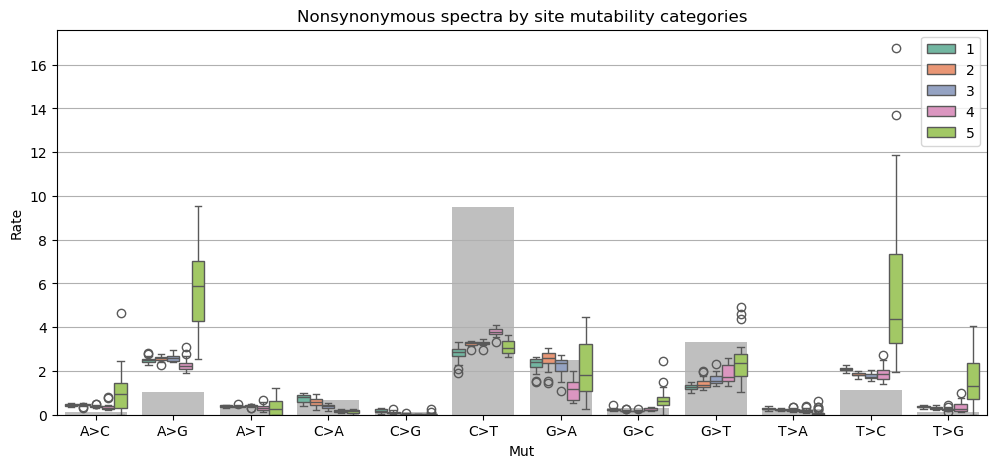

In [37]:
_ = cat_spectra_ns.melt(ignore_index=False, value_name='Rate').reset_index()
cur_syn_spec = spectrum_24A#.assign(rate_cat='SYN_20A')
cur_syn_spec['Rate'] = (cur_syn_spec['count'] / cur_syn_spec['count'].sum()) / \
    (cur_syn_spec['parent_nt_frac'] / cur_syn_spec['parent_nt_frac'].sum())

# _ = pd.concat([_, cur_syn_spec[['clade', 'rate_cat', 'Mut', 'Rate']]], 
#               ignore_index=True)

plt.figure(figsize=(12, 5))
ax = sns.boxplot(data=_, x='Mut', y='Rate', hue='rate_cat', palette='Set2')
sns.barplot(data=cur_syn_spec, x='Mut', y='Rate', color='gray', alpha=0.5, ax=ax)
plt.title('Nonsynonymous spectra by site mutability categories')
plt.grid(axis='y')


#### compare SYN and NONSYN

In [39]:
cat_spectra

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2         0.312517  2.239703  0.729206  0.000000  0.000000  1.416091   
      3         0.436757  2.064672  0.813957  0.745192  0.000000  3.875000   
      4         0.504068  2.156292  0.336046  0.159720  0.020833  2.749957   
      5              NaN       NaN       NaN  0.045455  0.060606  2.803030   
...                  ...       ...       ...       ...       ...       ...   
24E   1         0.000000  1.690909  0.000000  0.000000  0.000000  0.000000   
      2         0.257116  2.314044  0.235690  0.000000  0.000000  0.582528   
      3         0.281792  2.001449  0.563585  0.325459  0.054243  3.254593   
      4         0.086150  0.947653  0.484595  0.277724  0.029375  3.378090   
      5              NaN       inf       NaN  0.083004  0.018445  2.812912   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   1         0.000000  0.000000  0.000000  8.017241  0.000000  0.000000  
      2         0.985107  0.000000  0.656738  0.190857  2.372080  0.463510  
      3         0.305455  0.101818  1.120002  0.515576  1.853287  0.459838  
      4         0.734259  0.309162  2.357359  0.515270  1.636739  0.212170  
      5         0.519481  0.935065  2.285714  1.454545  0.727273  0.000000  
...                  ...       ...       ...       ...       ...       ...  
24E   1         0.000000  0.000000  0.000000  1.603448  4.810345  0.000000  
      2         0.135079  0.000000  0.135079  0.302831  2.882499  0.235535  
      3         1.074660  0.148229  0.852317  0.486866  2.459687  0.228218  
      4         1.193828  0.064397  1.555444  0.454570  1.352053  0.244768  
      5         0.442688  0.347826  1.675889  6.861660  3.541502  0.221344  

[149 rows x 12 columns]

In [40]:
cat_spectra_ns

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   2         0.483142  2.261776  0.487919  0.281643  0.062433  3.205407   
      3         0.442236  2.566567  0.447891  0.186711  0.035088  3.302603   
      4         0.816962  2.775964  0.597777  0.163334  0.035182  3.320861   
      5         0.333400  2.534665  0.000000  0.223010  0.279175  3.049199   
20A   1         0.506038  2.325375  0.451723  0.703168  0.185551  3.128154   
...                  ...       ...       ...       ...       ...       ...   
24C   5         0.082064  6.401015  0.000000  0.262606  0.059683  2.630061   
24E   1         0.378948  2.610739  0.460554  0.453245  0.099162  3.110092   
      3         0.333536  2.654041  0.316122  0.320435  0.057588  3.458967   
      4         0.289695  3.087011  0.651374  0.183392  0.027136  3.737186   
      5         0.000000  5.203973  0.059136  0.204702  0.042240  3.049203   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   2         1.543770  0.253604  1.945679  0.304881  1.794028  0.424189  
      3         1.097447  0.193328  2.297629  0.367729  1.736560  0.423008  
      4         0.852495  0.297273  2.224593  0.380050  2.749776  0.980540  
      5         1.275616  0.359492  1.901827  0.011597  3.339793  1.078475  
20A   1         2.190186  0.239485  1.362586  0.331952  2.035517  0.387422  
...                  ...       ...       ...       ...       ...       ...  
24C   5         3.262056  0.820643  4.595601  0.000000       NaN  1.230964  
24E   1         2.414917  0.166216  1.452415  0.195861  2.031240  0.285102  
      3         1.955505  0.229215  1.712211  0.191271  1.847617  0.168042  
      4         1.192903  0.324584  1.980291  0.298226  1.407433  0.440555  
      5         0.689921  0.887041  4.361284  0.088704  3.548164  0.709633  

[142 rows x 12 columns]

In [52]:
total_spectra = pd.concat([cat_spectra.assign(mut_type='SYN').reset_index(),
                           cat_spectra_ns.assign(mut_type='NONSYN').reset_index()], ignore_index=False)
total_spectra

Mut clade  rate_cat       A>C       A>G       A>T       C>A       C>G  \
0     19A         1  0.000000  0.000000  0.000000  0.000000  0.000000   
1     19A         2  0.312517  2.239703  0.729206  0.000000  0.000000   
2     19A         3  0.436757  2.064672  0.813957  0.745192  0.000000   
3     19A         4  0.504068  2.156292  0.336046  0.159720  0.020833   
4     19A         5       NaN       NaN       NaN  0.045455  0.060606   
..    ...       ...       ...       ...       ...       ...       ...   
137   24C         5  0.082064  6.401015  0.000000  0.262606  0.059683   
138   24E         1  0.378948  2.610739  0.460554  0.453245  0.099162   
139   24E         3  0.333536  2.654041  0.316122  0.320435  0.057588   
140   24E         4  0.289695  3.087011  0.651374  0.183392  0.027136   
141   24E         5  0.000000  5.203973  0.059136  0.204702  0.042240   

Mut       C>T       G>A       G>C       G>T       T>A       T>C       T>G  \
0    0.000000  0.000000  0.000000  0.000000  8.017241  0.000000  0.000000   
1    1.416091  0.985107  0.000000  0.656738  0.190857  2.372080  0.463510   
2    3.875000  0.305455  0.101818  1.120002  0.515576  1.853287  0.459838   
3    2.749957  0.734259  0.309162  2.357359  0.515270  1.636739  0.212170   
4    2.803030  0.519481  0.935065  2.285714  1.454545  0.727273  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
137  2.630061  3.262056  0.820643  4.595601  0.000000       NaN  1.230964   
138  3.110092  2.414917  0.166216  1.452415  0.195861  2.031240  0.285102   
139  3.458967  1.955505  0.229215  1.712211  0.191271  1.847617  0.168042   
140  3.737186  1.192903  0.324584  1.980291  0.298226  1.407433  0.440555   
141  3.049203  0.689921  0.887041  4.361284  0.088704  3.548164  0.709633   

Mut mut_type  
0        SYN  
1        SYN  
2        SYN  
3        SYN  
4        SYN  
..       ...  
137   NONSYN  
138   NONSYN  
139   NONSYN  
140   NONSYN  
141   NONSYN  

[291 rows x 15 columns]

In [50]:
_

Mut                           A>C       A>G       A>T       C>A       C>G  \
clade rate_cat mut_type                                                     
20I   1        SYN       0.000000  1.138112  0.325175  0.000000  0.000000   
      2        SYN       0.280800  2.287997  0.395199  0.047125  0.000000   
      3        SYN       0.299376  2.077119  0.700884  0.522337  0.043129   
      4        SYN       0.062659  0.903525  0.304011  0.200652  0.018224   
      5        SYN            inf       inf  0.000000  0.062082  0.255527   
...                           ...       ...       ...       ...       ...   
24A   1        NONSYN    0.406762  2.451513  0.406070  0.910545  0.287960   
      2        NONSYN    0.430926  2.528469  0.365408  0.703243  0.158097   
      3        NONSYN    0.375816  2.612720  0.405434  0.379138  0.033379   
      4        NONSYN    0.385993  2.474622  0.422880  0.198896  0.029331   
      5        NONSYN    0.872910  9.038846  0.028158  0.174878  0.049038   

Mut                           C>T       G>A       G>C       G>T       T>A  \
clade rate_cat mut_type                                                     
20I   1        SYN       0.000000  0.000000  0.000000  0.000000  0.308355   
      2        SYN       1.531560  0.240405  0.000000  0.229478  0.344789   
      3        SYN       3.733034  1.014878  0.042559  1.050890  0.536304   
      4        SYN       3.133313  0.759007  0.062628  2.561694  0.403565   
      5        SYN       2.727121  0.495630  0.242674  1.410797  1.468380   
...                           ...       ...       ...       ...       ...   
24A   1        NONSYN    2.595727  2.357467  0.246499  1.163475  0.328828   
      2        NONSYN    3.379910  2.887835  0.156970  1.250151  0.245096   
      3        NONSYN    3.332476  2.392516  0.157173  1.520154  0.215209   
      4        NONSYN    4.077638  1.274735  0.190105  1.536544  0.219937   
      5        NONSYN    3.015862  3.311428  2.446652  2.809583  0.014079   

Mut                           T>C       T>G  
clade rate_cat mut_type                      
20I   1        SYN       5.704576  0.616711  
      2        SYN       2.572307  0.366565  
      3        SYN       2.043065  0.366945  
      4        SYN       1.303631  0.725914  
      5        SYN       1.353213  0.057584  
...                           ...       ...  
24A   1        NONSYN    2.116575  0.406701  
      2        NONSYN    1.785077  0.304919  
      3        NONSYN    1.714155  0.216157  
      4        NONSYN    1.643372  0.233617  
      5        NONSYN    9.667717  0.886990  

[70 rows x 12 columns]

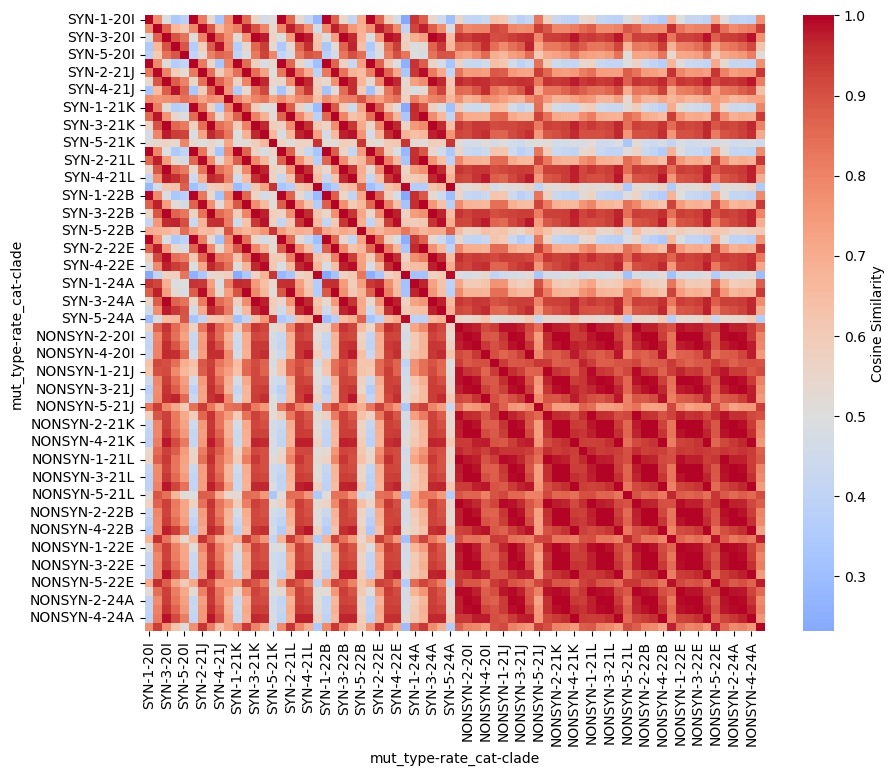

In [59]:
clds = ['20I', '21J', '21K', '21L', '22B', '22E', '24A']
_ = total_spectra.query('clade in @clds')\
    .set_index(['mut_type', 'rate_cat', 'clade',])\
        .replace([np.inf], np.nan).fillna(0)
_comp = pd.DataFrame(1-squareform(pdist(_, metric='cosine')), 
    columns=_.index, index=_.index)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(_comp, cmap='coolwarm', center=0.5, cbar_kws={'label': 'Cosine Similarity'})

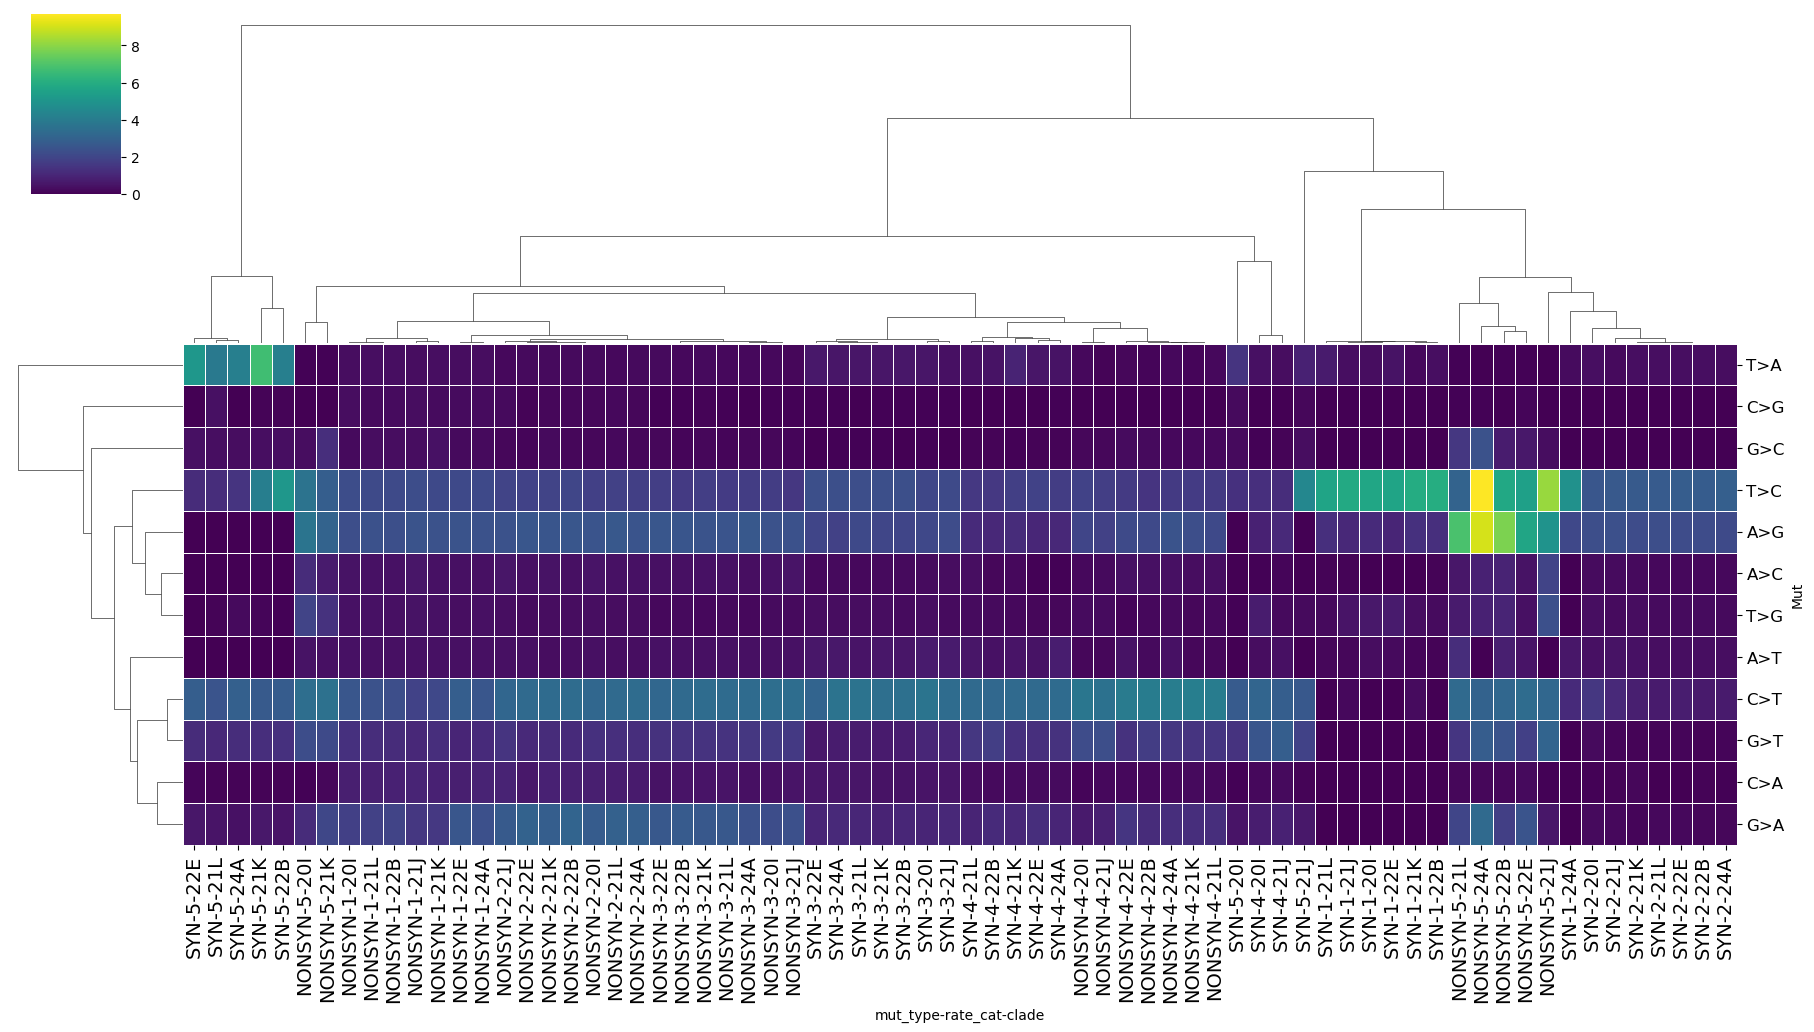

In [106]:
g = sns.clustermap(_.T, metric='cosine', cmap='viridis', figsize=(18, 10), 
    # annot=True, fmt='.1f', 
    linewidth=.5,
    dendrogram_ratio=(.1, .4))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=12, rotation=0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=14);

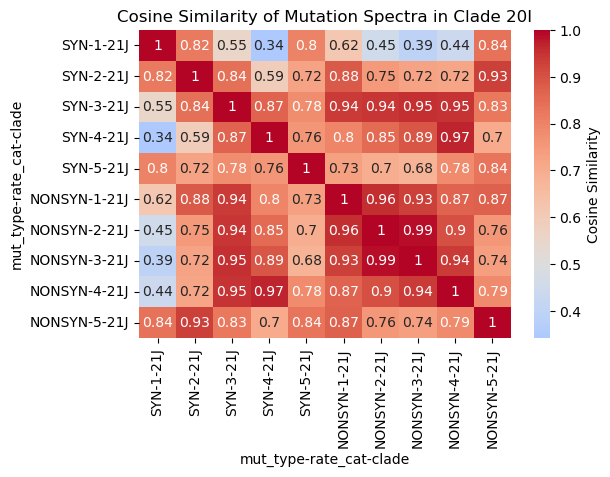

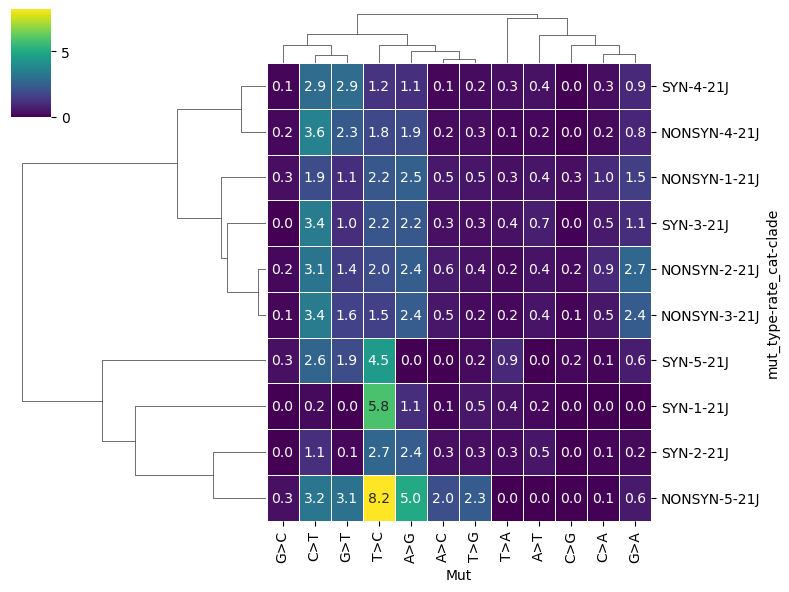

In [113]:
clds = ['21J']
_ = total_spectra.query('clade in @clds')\
    .set_index(['mut_type', 'rate_cat', 'clade',])\
        .replace([np.inf], np.nan).fillna(0)
_comp = pd.DataFrame(1-squareform(pdist(_, metric='cosine')), 
    columns=_.index, index=_.index)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(_comp, cmap='coolwarm', center=0.5, annot=True, cbar_kws={'label': 'Cosine Similarity'})
plt.title('Cosine Similarity of Mutation Spectra in Clade 20I')

g = sns.clustermap(_, metric='cosine', cmap='viridis',  figsize=(8, 6),
    annot=True, fmt='.1f', 
    linewidth=.5,
    dendrogram_ratio=(.4, .1))

# g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=12, rotation=0)
# g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=14);

### Explore categories

In [23]:
site_different_cats = ref_sites_df_clades_cat.groupby(['nt_site', 'rate_cat_ns']).clade.unique().reset_index()
site_different_cats

nt_site  rate_cat_ns                                              clade
0          267            1                                         [21L, 22B]
1          268            1                                              [21L]
2          269            1                                    [20J, 21I, 24E]
3          269            2                               [20A, 20C, 20G, 23A]
4          269            3                [20B, 20E, 21J, 21K, 22A, 22D, 24B]
...        ...          ...                                                ...
68742    29671            0  [20B, 20C, 20E, 20G, 20I, 21I, 21J, 21L, 22A, ...
68743    29671            1                                              [21K]
68744    29672            0  [20A, 20C, 21I, 21J, 21K, 21L, 22A, 22B, 22D, ...
68745    29673            0  [20A, 20I, 20J, 21J, 21K, 22A, 22B, 22C, 22E, ...
68746    29674            0  [19A, 20A, 20B, 20C, 20E, 20G, 20I, 21C, 21I, ...

[68747 rows x 3 columns]

In [ ]:
# there is a lot of rate cat imbalabces

_s =site_different_cats.nt_site.value_counts()
_s[_s>1]

site_different_cats[site_different_cats.nt_site.isin(_s[_s==6].index)].head(30)

nt_site  rate_cat_ns                                              clade
790        526            0                                              [23E]
791        526            1                                         [22D, 23C]
792        526            2                               [19A, 21C, 22F, 24C]
793        526            3                               [20J, 23B, 23D, 24E]
794        526            4  [20A, 20B, 20C, 20E, 20G, 20I, 21I, 21J, 21K, ...
795        526            5                                              [20F]
7501      3004            0                                              [24C]
7502      3004            1                                         [21C, 22D]
7503      3004            2                                         [23B, 24B]
7504      3004            3                               [19A, 20J, 23C, 23D]
7505      3004            4  [20A, 20B, 20C, 20E, 20G, 20I, 21I, 21J, 21K, ...
7506      3004            5                                              [20F]
11208     4396            0                     [20A, 20B, 20G, 21I, 21J, 21K]
11209     4396            1                                         [20E, 20I]
11210     4396            2                                         [22A, 24C]
11211     4396            3                                         [22C, 24B]
11212     4396            4           [21L, 22B, 22D, 22F, 23A, 23B, 23C, 23E]
11213     4396            5                               [22E, 23D, 23F, 24A]
13036     5164            0                               [19A, 20J, 22D, 23C]
13037     5164            1           [20A, 20C, 20E, 22A, 22C, 23D, 23F, 24A]
13038     5164            2                          [20B, 22B, 22E, 22F, 23A]
13039     5164            3           [20G, 20I, 21K, 21L, 23B, 24B, 24C, 24E]
13040     5164            4                                              [21J]
13041     5164            5                                              [21I]
22136     9053            0                                              [21J]
22137     9053            1                                    [20E, 22D, 23E]
22138     9053            2                          [20B, 20J, 22A, 24A, 24B]
22139     9053            3                [20C, 20G, 20I, 22E, 22F, 23B, 23D]
22140     9053            4           [19A, 20A, 21K, 21L, 22B, 22C, 23A, 23F]
22141     9053            5                                              [21I]

In [15]:
ref_sites_df.groupby('rate_cat')['MutCountTotal'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count     mean     std     min     max        sum
rate_cat                                                   
0           705     0.00    0.00     0.0     0.0        0.0
1          6501     9.50    7.64     1.0    26.0    61742.0
2          9047    57.11   18.67    27.0    92.0   516707.0
3          7467   145.15   38.98    93.0   234.0  1083867.0
4          5254   609.88  411.63   235.0  1921.0  3204302.0
5           286  2604.62  894.89  1925.0  8529.0   744921.0

In [32]:
ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count     mean     std     min     max        sum
rate_cat_ns                                                   
0             6159     0.00    0.00     0.0     0.0        0.0
1             6410     4.43    3.09     1.0    11.0    28382.0
2             6613    29.35   12.08    12.0    53.0   194124.0
3             5322    93.39   28.04    54.0   154.0   497043.0
4             4523   431.64  319.47   155.0  1576.0  1952290.0
5              233  2161.03  856.50  1579.0  8529.0   503520.0

In [66]:
_ = ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg(['count','sum']).round(2)
_ / _.sum()

count       sum
rate_cat_ns                    
0            0.210492  0.000000
1            0.219070  0.008938
2            0.226008  0.061135
3            0.181887  0.156531
4            0.154580  0.614825
5            0.007963  0.158571

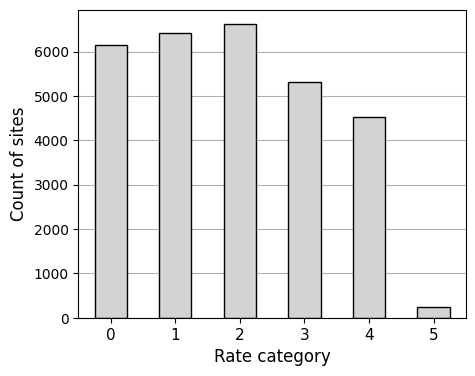

In [67]:
plt.figure(figsize=(5, 4))
ax = ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg('count').plot.bar(color='lightgray', edgecolor='k')
ax.set_xlabel('Rate category', fontsize=12)
ax.set_ylabel('Count of sites', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.set_axisbelow(True)
ax.grid(axis='y')

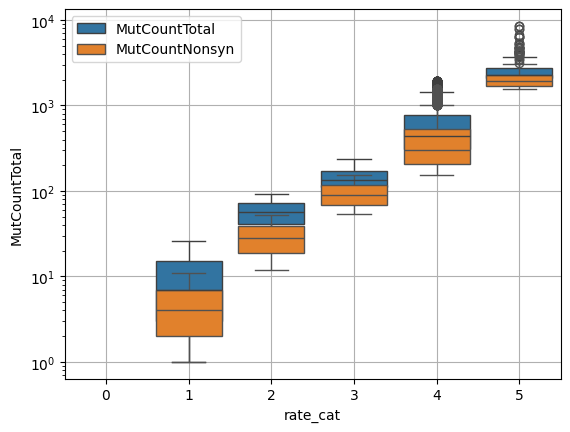

In [18]:
sns.boxplot(ref_sites_df, x='rate_cat', y='MutCountTotal', label='MutCountTotal')
sns.boxplot(ref_sites_df, x='rate_cat_ns', y='MutCountNonsyn', label='MutCountNonsyn')
plt.yscale('log')
plt.legend()
plt.grid(True)

In [69]:
ref_sites_df.groupby('rate_cat').MutCountTotal.agg(['min', 'max',])

min     max
rate_cat                
0            0.0     0.0
1            1.0    26.0
2           27.0    92.0
3           93.0   234.0
4          235.0  1921.0
5         1925.0  8529.0

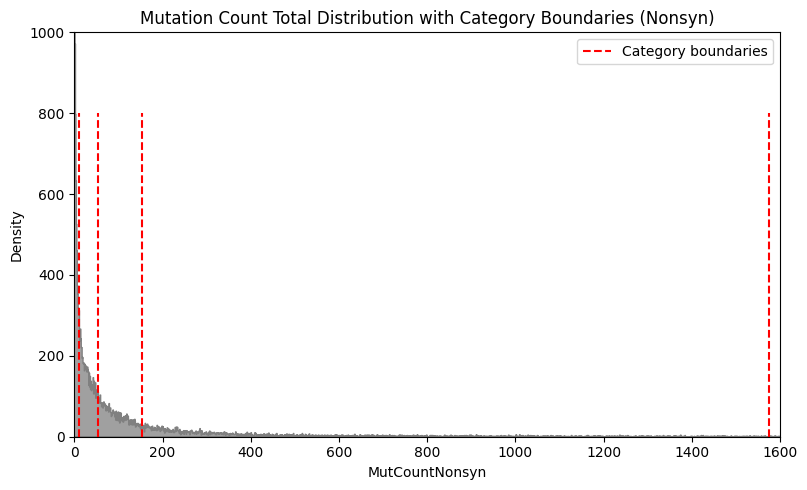

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(ref_sites_df, x='MutCountNonsyn', color='gray', element='step', discrete=True)
plt.vlines(ref_sites_df.groupby('rate_cat_ns').MutCountNonsyn.agg('max').iloc[1:-1].values, 
           ymin=0, ymax=800, color='red', linestyle='--', label='Category boundaries')

plt.title("Mutation Count Total Distribution with Category Boundaries (Nonsyn)")
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.xlim(0, 1600)
plt.ylim(0, 1000)
plt.show()

<Axes: xlabel='rate_cat_ns', ylabel='site_count'>

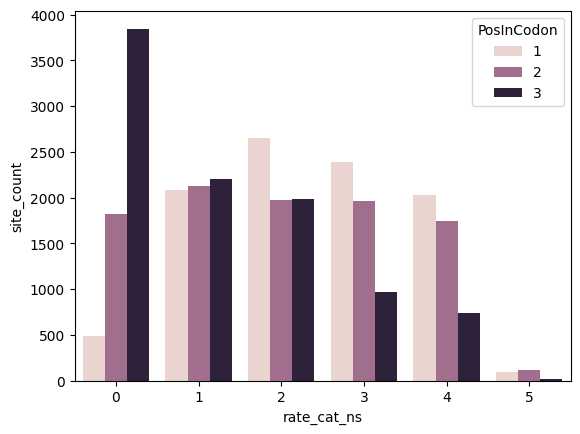

In [68]:
# 3rd pos in 0-cat is normal because 3rd pos usually have no missense sbs
_ = ref_sites_df.groupby('rate_cat_ns').PosInCodon.value_counts().rename('site_count').reset_index()
sns.barplot(_, x='rate_cat_ns', y='site_count', hue='PosInCodon')

<Axes: xlabel='rate_cat', ylabel='site_count'>

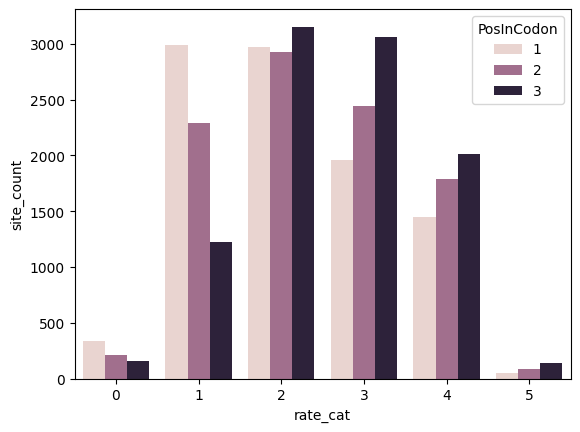

In [69]:
_ = ref_sites_df.groupby('rate_cat').PosInCodon.value_counts().rename('site_count').reset_index()
sns.barplot(_, x='rate_cat', y='site_count', hue='PosInCodon')

In [67]:
ref_sites_df[ref_sites_df.MutCountNonsyn == 0].PosInCodon.value_counts()

PosInCodon
3    3847
2    1826
1     486
Name: count, dtype: int64

In [13]:
cat_aa_content = ref_sites_df.groupby('rate_cat_ns').AA.value_counts().unstack()
cat_aa_content = cat_aa_content.div(cat_aa_content.sum(1), axis=0).fillna(0)
cat_aa_content

AA                  *       Ala       Arg       Asn       Asp       Cys  \
rate_cat_ns                                                               
0            0.022569  0.089300  0.033285  0.022082  0.011041  0.024355   
1            0.024961  0.018409  0.030733  0.056318  0.036973  0.054290   
2            0.022683  0.025556  0.021624  0.080145  0.049599  0.024044   
3            0.011086  0.050169  0.031003  0.068207  0.048666  0.019542   
4            0.008623  0.109220  0.047756  0.016140  0.049746  0.016140   
5            0.000000  0.107296  0.042918  0.004292  0.021459  0.000000   

AA                Gln       Glu       Gly       His  ...       Leu       Lys  \
rate_cat_ns                                          ...                       
0            0.029550  0.008605  0.078584  0.022731  ...  0.155869  0.016236   
1            0.038066  0.029953  0.043682  0.024961  ...  0.161466  0.054758   
2            0.046121  0.051868  0.028126  0.020414  ...  0.118706  0.092999   
3            0.046787  0.077039  0.037580  0.019542  ...  0.071402  0.077039   
4            0.038912  0.038249  0.061906  0.029184  ...  0.095070  0.032501   
5            0.072961  0.008584  0.030043  0.068670  ...  0.120172  0.012876   

AA                Met       Phe       Pro       Ser       Thr       Trp  \
rate_cat_ns                                                               
0            0.017048  0.021919  0.056990  0.079558  0.099204  0.005196   
1            0.026677  0.074103  0.017941  0.057098  0.037598  0.018409   
2            0.029790  0.068199  0.013610  0.061848  0.071375  0.008771   
3            0.051297  0.040962  0.019166  0.071026  0.063886  0.007704   
4            0.036922  0.013044  0.070086  0.074950  0.088658  0.011718   
5            0.008584  0.000000  0.115880  0.120172  0.214592  0.004292   

AA                Tyr       Val  
rate_cat_ns                      
0            0.049846  0.123559  
1            0.056162  0.056474  
2            0.043853  0.064419  
3            0.031567  0.072529  
4            0.017687  0.090206  
5            0.004292  0.025751  

[6 rows x 21 columns]

<Axes: xlabel='rate_cat_ns', ylabel='rate_cat_ns'>

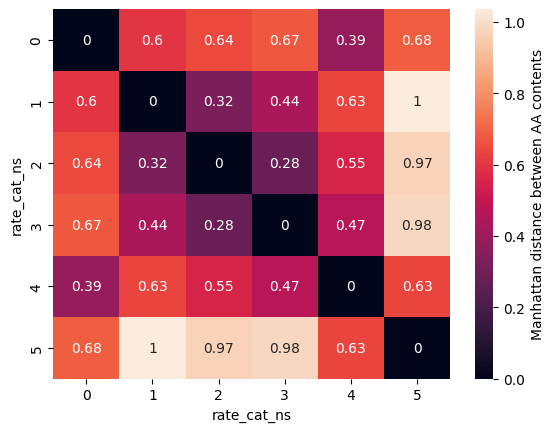

In [62]:
_ = pd.DataFrame(squareform(pdist(cat_aa_content, 'cityblock')), 
                 index=cat_aa_content.index, columns=cat_aa_content.index)
sns.heatmap(_, annot=True, cbar_kws={'label': 'Manhattan distance between AA contents'})

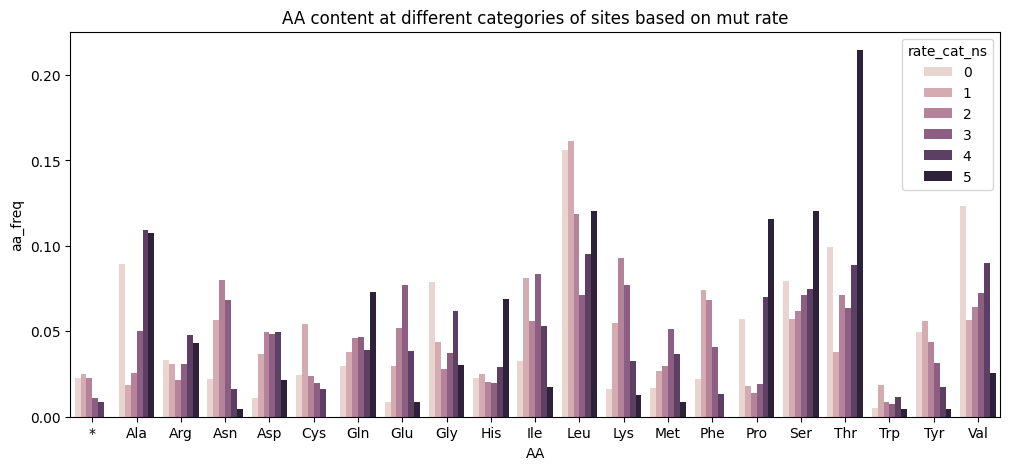

In [52]:
plt.figure(figsize=(12, 5))
_ = cat_aa_content.melt(ignore_index=False, value_name='aa_freq').reset_index()
sns.barplot(_, hue='rate_cat_ns', y='aa_freq', x='AA')
plt.title('AA content at different categories of sites based on mut rate');

In [75]:
obs

protein    aa_mutation nt_mutation     codon_change  nt_site  \
0              ORF1ab         P5401L     C16466T          CCA>CTA    16466   
1                   M           I82T     T26767C          ATC>ACC    26767   
3              ORF1ab         P4715L     C14408T          CCT>CTT    14408   
4              ORF1ab         A6319V     C19220T          GCT>GTT    19220   
5              ORF1ab         I5658V     A17236G          ATA>GTA    17236   
...               ...            ...         ...              ...      ...   
1553870  ORF1a;ORF1ab  V4369A;V4369A     T13371C  GTC>GCC;GTC>GCC    13371   
1553871  ORF1a;ORF1ab  V4350A;V4350A     T13314C  GTA>GCA;GTA>GCA    13314   
1553874  ORF1a;ORF1ab  V3763F;V3763F     G11552T  GTT>TTT;GTT>TTT    11552   
1553875  ORF1a;ORF1ab  V3759G;V3759G     T11541G  GTT>GGT;GTT>GGT    11541   
1553876  ORF1a;ORF1ab  V4102A;V4102A     T12570C  GTA>GCA;GTA>GCA    12570   

        reference_nt clade_founder_nt  exclude  count  count_terminal  ...  \
0                  C                C    False     70              37  ...   
1                  T                T    False     58              18  ...   
3                  C                C    False     52              26  ...   
4                  C                C    False     50              15  ...   
5                  A                A    False     48              24  ...   
...              ...              ...      ...    ...             ...  ...   
1553870            T                T    False      1               1  ...   
1553871            T                T    False      1               1  ...   
1553874            G                G    False      1               1  ...   
1553875            T                T    False      1               0  ...   
1553876            T                T    False      1               0  ...   

         mean_log_size  clade subset    codon codon_position codon_site  Mut  \
0             0.708825    19A    all      CCA              2       5401  C>T   
1             1.237886    19A    all      ATC              2         82  T>C   
3             0.678436    19A    all      CCT              2       4715  C>T   
4             1.097059    19A    all      GCT              2       6319  C>T   
5             0.581333    19A    all      ATA              1       5658  A>G   
...                ...    ...    ...      ...            ...        ...  ...   
1553870       0.000000    24E    all  GTC;GTC            2;2  4369;4369  T>C   
1553871       0.000000    24E    all  GTA;GTA            2;2  4350;4350  T>C   
1553874       0.000000    24E    all  GTT;GTT            1;1  3763;3763  G>T   
1553875       0.693147    24E    all  GTT;GTT            2;2  3759;3759  T>G   
1553876       1.098612    24E    all  GTA;GTA            2;2  4102;4102  T>C   

        aa1 aa2 aa_site  
0         P   L    5401  
1         I   T      82  
3         P   L    4715  
4         A   V    6319  
5         I   V    5658  
...      ..  ..     ...  
1553870   V   A    4369  
1553871   V   A    4350  
1553874   V   F    3763  
1553875   V   G    3759  
1553876   V   A    4102  

[440648 rows x 21 columns]

In [86]:
ref_sites_df[['gene', 'aa_site', 'rate_cat', 'rate_cat_ns']]

gene  aa_site  rate_cat  rate_cat_ns
0      ORF1ab      NaN         0            0
1      ORF1ab      1.0         1            1
2      ORF1ab      1.0         1            1
3      ORF1ab      2.0         4            4
4      ORF1ab      2.0         3            3
...       ...      ...       ...          ...
29255   ORF10     38.0         4            4
29256   ORF10     38.0         3            1
29257   ORF10      NaN         2            0
29258   ORF10      NaN         2            0
29259   ORF10      NaN         3            0

[29260 rows x 4 columns]

In [22]:
obs['gene'] = obs['protein'].replace('ORF1a;ORF1ab', 'ORF1ab')
obs['MutAA'] = obs['aa1'] + '>' + obs['aa2']

In [24]:
_sites_cat = ref_sites_df[['nt_site', 'rate_cat', 'rate_cat_ns']].dropna()
_sites_cat['nt_site'] = _sites_cat['nt_site'].astype(int)
_sites_cat

nt_site  rate_cat  rate_cat_ns
1          267         1            1
2          268         1            1
3          269         4            4
4          270         3            3
5          271         3            3
...        ...       ...          ...
29251    29666         4            5
29252    29667         3            3
29254    29669         3            3
29255    29670         4            4
29256    29671         3            1

[23101 rows x 3 columns]

In [27]:
cat_obs = obs[['clade', 'gene', 'nt_site', 'aa_site', 'aa_mutation', 'MutAA', 'count']]\
    .merge(ref_sites_df_clades_cat, on=['clade', 'gene', 'nt_site'])
print(cat_obs.shape)
cat_obs_mut_freqs = cat_obs.groupby(['rate_cat_ns', 'MutAA'])['count'].sum().unstack().fillna(0)
cat_obs_mut_freqs

(440648, 19)


MutAA        *>C   *>E   *>G  *>K   *>L    *>Q  *>R   *>S  *>W  *>Y  ...  \
rate_cat_ns                                                          ...   
1            2.0   1.0   0.0  0.0   0.0    0.0  1.0   0.0  1.0  6.0  ...   
2            3.0   1.0   0.0  3.0   3.0    1.0  8.0   0.0  2.0  2.0  ...   
3            6.0   2.0   1.0  2.0  12.0    5.0  3.0   4.0  3.0  4.0  ...   
4            4.0  62.0  12.0  6.0  39.0   38.0  1.0  10.0  9.0  3.0  ...   
5            0.0  55.0  12.0  2.0   1.0  105.0  0.0   0.0  0.0  0.0  ...   

MutAA           W>L     W>R    W>S    Y>*     Y>C    Y>D    Y>F     Y>H  \
rate_cat_ns                                                               
1             343.0   272.0   52.0  262.0  1621.0   43.0  693.0  2215.0   
2             598.0   370.0   53.0  299.0  3910.0   77.0  906.0  5117.0   
3             772.0  1231.0   64.0  112.0  5544.0  100.0  694.0  7011.0   
4            6048.0  1447.0  568.0   39.0  6230.0  538.0  572.0  8603.0   
5             231.0    13.0   23.0    0.0    55.0  300.0  230.0   765.0   

MutAA          Y>N    Y>S  
rate_cat_ns                
1            117.0   85.0  
2            263.0  183.0  
3            369.0  268.0  
4            506.0  279.0  
5             29.0   40.0  

[5 rows x 170 columns]

In [28]:
def calc_entropy(freqs: pd.Series):
    if len(freqs) == 1:
        return 0.0
    p = freqs / freqs.sum()
    p = p[p > 0]
    H = - (p * np.log2(p)).sum()
    return H

entropy = cat_obs.groupby(['clade', 'gene', 'rate_cat_ns', 'aa_site', 'MutAA'])['count'].sum()\
    .reset_index().groupby(['clade', 'gene', 'rate_cat_ns', 'aa_site'])['count']\
        .apply(calc_entropy)

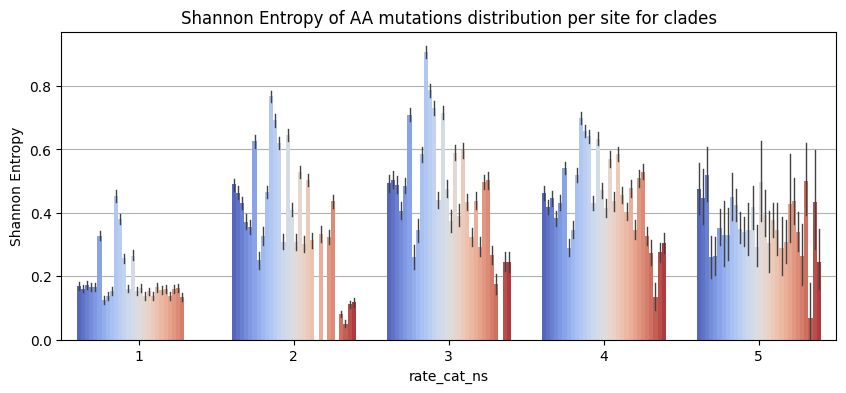

In [29]:
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=entropy.rename('entropy').reset_index(), 
            x='rate_cat_ns', y='entropy', hue='clade', legend=False,
            palette='coolwarm', err_kws={'linewidth':1}
)
plt.title('Shannon Entropy of AA mutations distribution per site for clades')
plt.ylabel('Shannon Entropy')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [119]:
for c in range(1, 6):
    print('rate_cat', c)
    print(cat_obs_mut_freqs.loc[c].sort_values(ascending=False).head(10))
    print()

rate_cat 1
MutAA
F>L    1475.0
I>M    1042.0
D>E     985.0
N>K     949.0
V>A     947.0
L>F     916.0
K>N     866.0
L>V     769.0
L>S     718.0
L>P     592.0
Name: 1, dtype: float64

rate_cat 2
MutAA
V>A    10515.0
T>A     9437.0
F>L     8527.0
D>E     6465.0
K>R     6306.0
E>D     5810.0
K>E     5168.0
K>N     5018.0
N>K     4837.0
N>D     4493.0
Name: 2, dtype: float64

rate_cat 3
MutAA
I>V    24067.0
V>I    18389.0
N>S    16993.0
K>R    16849.0
T>A    15925.0
A>T    13491.0
I>T    13422.0
F>L    11796.0
E>G    11747.0
D>G    11245.0
Name: 3, dtype: float64

rate_cat 4
MutAA
T>I    231464.0
A>V    171438.0
L>F    117184.0
P>S    106918.0
P>L     72998.0
A>S     64104.0
S>F     59877.0
V>F     53291.0
V>I     52632.0
H>Y     50011.0
Name: 4, dtype: float64

rate_cat 5
MutAA
T>I    107777.0
A>V     58422.0
L>F     42398.0
P>L     35079.0
H>Y     30637.0
S>F     29971.0
S>L     29378.0
P>S     23603.0
K>R     18250.0
R>C     12112.0
Name: 5, dtype: float64



<Axes: xlabel='rate_cat_ns', ylabel='rate_cat_ns'>

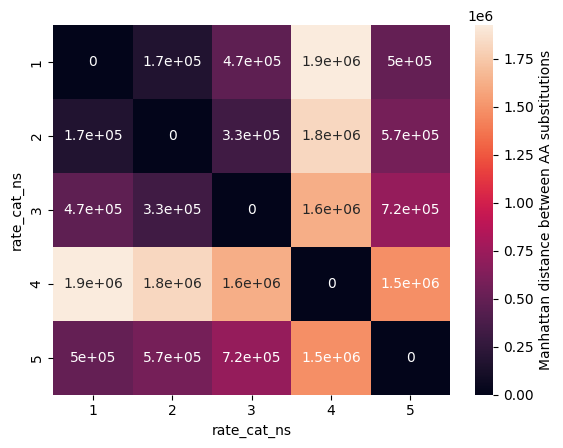

In [122]:
_ = pd.DataFrame(squareform(pdist(cat_obs_mut_freqs, 'cityblock')), 
                 index=cat_obs_mut_freqs.index, columns=cat_obs_mut_freqs.index)
sns.heatmap(_, annot=True, cbar_kws={'label': 'Manhattan distance between AA substitutions'})

In [137]:
cat_obs_mut_freqs.sum().describe()

count       170.000000
mean      18678.582353
std       39811.901672
min          13.000000
25%        1698.500000
50%        5304.000000
75%       16525.500000
max      348170.000000
dtype: float64

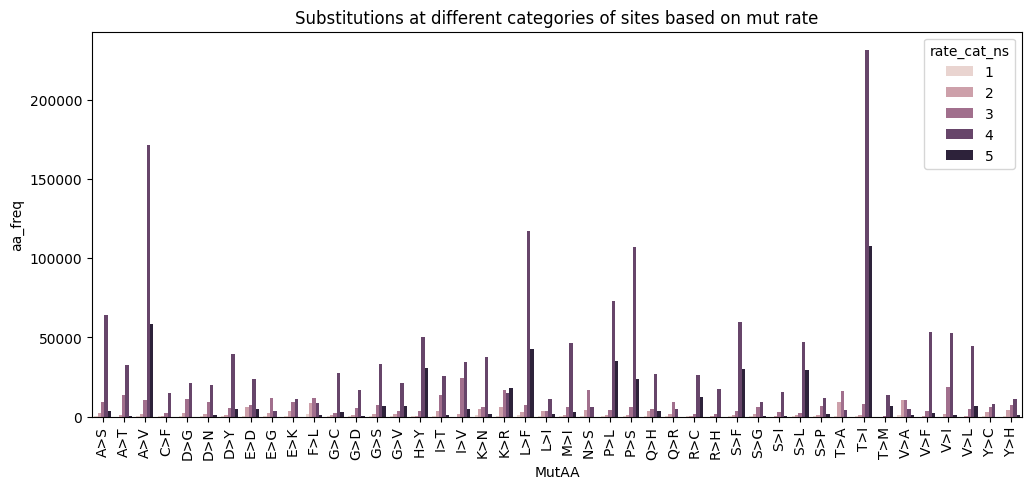

In [143]:
plt.figure(figsize=(12, 5))
_ = cat_obs_mut_freqs.loc[:, cat_obs_mut_freqs.sum() > 16000]\
    .melt(ignore_index=False, value_name='aa_freq').reset_index()
sns.barplot(_, hue='rate_cat_ns', y='aa_freq', x='MutAA')
plt.xticks(rotation=90)
plt.title('Substitutions at different categories of sites based on mut rate');

#### compare rate categories with "landscape" categories

In [33]:
# compare with landscapes
df_land = pd.read_csv('./data/sites_landscape_labels.csv')
df_land

gene  aa_site     min      max      mean   median       std  count  \
0         E        1 -7.1032 -3.15600 -4.558900 -4.20155  1.412269      6   
1         E        2 -5.1893 -2.27390 -3.369967 -3.16075  0.991358      6   
2         E        3 -2.4956 -0.76330 -1.350945 -1.07244  0.782417      4   
3         E        4 -3.1612 -0.36699 -2.383348 -2.82070  1.099300      6   
4         E        5 -3.5840  0.72401 -1.498047 -2.14025  1.698920      6   
...     ...      ...     ...      ...       ...      ...       ...    ...   
16759  nsp9      109 -5.1893  1.11350 -2.792800 -3.35530  2.174497      6   
16760  nsp9      110 -5.1071 -1.46820 -2.825300 -2.48540  1.395265      5   
16761  nsp9      111 -7.2405 -1.89070 -4.397983 -4.42670  1.752579      6   
16762  nsp9      112 -5.0843 -0.80668 -2.522769 -2.44460  1.528106      7   
16763  nsp9      113 -5.1893 -0.81593 -2.809438 -2.64880  1.468441      6   

       max=0 ref_aa  subset_of_ORF1ab      landscape_char  
0       True      M             False      ref_is_highest  
1       True      Y             False      ref_is_highest  
2       True      S             False      ref_is_highest  
3       True      F             False      ref_is_highest  
4      False      V             False  ref_is_not_highest  
...      ...    ...               ...                 ...  
16759  False      T              True  ref_is_not_highest  
16760   True      V              True      ref_is_highest  
16761   True      R              True      ref_is_highest  
16762   True      L              True      ref_is_highest  
16763   True      Q              True      ref_is_highest  

[16764 rows x 12 columns]

In [34]:
# sites that have no mutations have no aa_site in obs and therefore in ref_sites_df
# we must assign manually aa_site for invariant sites:

def get_site_aa(ser):
    # 13468
    nt_site = ser['Pos']
    gene_site = ser['PosInGene']
    gene = ser['gene']

    if gene != 'ORF1ab':
        return (gene_site - 1) // 3 + 1

    if nt_site <= 13468:
        return (gene_site - 1) // 3 + 1
    elif 13468 < nt_site < 13483:
        return np.nan
    else: 
        return gene_site // 3 + 1

ref_sites_df['aa_site_my'] = ref_sites_df.apply(get_site_aa, axis=1)
ref_sites_df.query('aa_site != aa_site_my & aa_site.notnull()')

Pos Nuc Context  Strand       Type    gene  PosInGene  PosInCodon  \
13215  13481   T     GTA       1  stem_loop  ORF1ab      13216           1   

      Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site  \
13215   TAA            6.0             6.0  13481.0              2   4406.0   

      AA  rate_cat  rate_cat_ns  aa_site_my  
13215  *         1            1         NaN

In [43]:
ref_sites_df['aa_site_from_obs'] = ref_sites_df['aa_site']
ref_sites_df['aa_site'] = ref_sites_df['aa_site_my']

In [44]:
big_label = ref_sites_df.merge(df_land[['gene', 'aa_site', 'landscape_char']])
big_label.query('gene == "S"')

Pos Nuc Context  Strand Type gene  PosInGene  PosInCodon Codon  \
21066  21563   A     AAT       1  CDS    S          1           1   ATG   
21067  21564   T     ATG       1  CDS    S          2           2   ATG   
21068  21565   G     TGT       1  CDS    S          3           3   ATG   
21069  21566   T     GTT       1  CDS    S          4           1   TTT   
21070  21567   T     TTT       1  CDS    S          5           2   TTT   
...      ...  ..     ...     ...  ...  ...        ...         ...   ...   
24835  25374   A     CAT       1  CDS    S       3812           2   CAT   
24836  25375   T     ATT       1  CDS    S       3813           3   CAT   
24837  25376   T     TTA       1  CDS    S       3814           1   TAC   
24838  25377   A     TAC       1  CDS    S       3815           2   TAC   
24839  25378   C     ACA       1  CDS    S       3816           3   TAC   

       MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site   AA  \
21066            0.0             0.0      NaN            NaN      1.0  Met   
21067            0.0             0.0      NaN            NaN      1.0  Met   
21068            2.0             2.0  21565.0              3      1.0  Met   
21069           54.0            54.0  21566.0              1      2.0  Phe   
21070           21.0            21.0  21567.0              2      2.0  Phe   
...              ...             ...      ...            ...      ...  ...   
24835            8.0             8.0  25374.0              2   1271.0  His   
24836           75.0             0.0      NaN            NaN   1271.0  His   
24837           50.0            50.0  25376.0              1   1272.0  Tyr   
24838            6.0             6.0  25377.0              2   1272.0  Tyr   
24839          490.0            17.0  25378.0              3   1272.0  Tyr   

       rate_cat  rate_cat_ns  aa_site_my  aa_site_from_obs      landscape_char  
21066         0            0         1.0               NaN      ref_is_highest  
21067         0            0         1.0               NaN      ref_is_highest  
21068         1            1         1.0               1.0      ref_is_highest  
21069         2            3         2.0               2.0  ref_is_not_highest  
21070         1            2         2.0               2.0  ref_is_not_highest  
...         ...          ...         ...               ...                 ...  
24835         1            1      1271.0            1271.0      ref_is_highest  
24836         2            0      1271.0               NaN      ref_is_highest  
24837         2            2      1272.0            1272.0      ref_is_highest  
24838         1            1      1272.0            1272.0      ref_is_highest  
24839         4            2      1272.0            1272.0      ref_is_highest  

[3774 rows x 20 columns]

In [48]:
big_label.gene.value_counts()

gene
ORF1ab    21066
S          3774
N          1242
ORF3a       825
M           663
ORF7a       359
ORF8        357
E           225
ORF6        183
ORF7b       123
ORF10       111
Name: count, dtype: int64

In [45]:
big_label.groupby('landscape_char').rate_cat_ns.value_counts().unstack()

rate_cat_ns              0       1       2       3       4      5
landscape_char                                                   
ref_is_highest      4071.0  5190.0  3906.0  2108.0  1342.0    NaN
ref_is_not_highest  1891.0  1184.0  2676.0  3175.0  3153.0  232.0

In [47]:
big_label.groupby('landscape_char').rate_cat_ns.value_counts().unstack().sum().sum()

np.float64(28928.0)

### Explore reverse mutations ratio in rate categories

In [51]:
def reciprocal_mut(mut: str) -> str:
    base_from, base_to = mut.split('>')
    return f"{base_to}>{base_from}"

# def divide_max_min(series: pd.Series, mut, mut_rev) -> pd.Series:
#     a = series.get(mut, 0)
#     b = series.get(mut_rev, 0)
#     if a == 0 and b == 0:
#         return np.nan
#     return max(a, b) / min(a, b) if min(a, b) > 0 else np.nan

In [52]:
# ref_sites_df_clades_cat = pd.read_csv('./data/ref_sites_rates_categories_clades.csv.gz')

In [54]:
cat_spectra

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      2         0.312517  2.239703  0.729206  0.000000  0.000000  1.416091   
      3         0.436757  2.064672  0.813957  0.745192  0.000000  3.875000   
      4         0.504068  2.156292  0.336046  0.159720  0.020833  2.749957   
      5              NaN       NaN       NaN  0.045455  0.060606  2.803030   
...                  ...       ...       ...       ...       ...       ...   
24E   1         0.000000  1.690909  0.000000  0.000000  0.000000  0.000000   
      2         0.257116  2.314044  0.235690  0.000000  0.000000  0.582528   
      3         0.281792  2.001449  0.563585  0.325459  0.054243  3.254593   
      4         0.086150  0.947653  0.484595  0.277724  0.029375  3.378090   
      5              NaN       inf       NaN  0.083004  0.018445  2.812912   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   1         0.000000  0.000000  0.000000  8.017241  0.000000  0.000000  
      2         0.985107  0.000000  0.656738  0.190857  2.372080  0.463510  
      3         0.305455  0.101818  1.120002  0.515576  1.853287  0.459838  
      4         0.734259  0.309162  2.357359  0.515270  1.636739  0.212170  
      5         0.519481  0.935065  2.285714  1.454545  0.727273  0.000000  
...                  ...       ...       ...       ...       ...       ...  
24E   1         0.000000  0.000000  0.000000  1.603448  4.810345  0.000000  
      2         0.135079  0.000000  0.135079  0.302831  2.882499  0.235535  
      3         1.074660  0.148229  0.852317  0.486866  2.459687  0.228218  
      4         1.193828  0.064397  1.555444  0.454570  1.352053  0.244768  
      5         0.442688  0.347826  1.675889  6.861660  3.541502  0.221344  

[149 rows x 12 columns]

In [66]:
cur_rate_cat = 'rate_cat_ns' # rate cats based on nonsynonymous mutations
mut_cnt_col = 'MutCountNonsyn' if cur_rate_cat == 'rate_cat_ns' else 'MutCountTotal'
print(cur_rate_cat)

datata = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    obs_clade = obs[obs['clade'] == clade]
    if obs_clade['count'].sum() < 93000:
        continue

    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    cur_ref_sites_df['Pos'] = cur_ref_sites_df['nt_site']
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df[mut_cnt_col], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df[cur_rate_cat] = categories

    for i, rcat in enumerate(cur_ref_sites_df[cur_rate_cat].unique()):
        if rcat <= 1:
            continue
        
        cur_ms = cat_spectra.loc[(clade, rcat)].replace([np.inf, -np.inf], np.nan)

        cur_sites = cur_ref_sites_df.query(f'{cur_rate_cat} == @rcat').Pos.tolist()
        df_obs = obs_clade[obs_clade.nt_site.isin(cur_sites)]

        # calc recurrent mutations
        hotspot_mut_counts = df_obs.groupby(['nt_site', 'Mut'])['count'].sum().unstack().fillna(0)
        for mut in ['G>T', 'C>G', 'C>T', 'A>T', 'A>G', 'T>G']:
            if mut not in hotspot_mut_counts.columns:
                continue
            mut_rev = reciprocal_mut(mut)
            expected_ratio = cur_ms.loc[mut] / cur_ms.loc[mut_rev] if cur_ms.loc[mut_rev] > 0 else np.nan
            # ratio = hotspot_mut_counts.apply(lambda x: divide_max_min(x, mut, mut_rev), axis=1).dropna()
            ratio = hotspot_mut_counts[mut].div(hotspot_mut_counts[mut_rev]).replace([np.inf, -np.inf], np.nan)
            datata.append(ratio.reset_index(name='ratio').assign(
                Mut=mut, clade=clade, rate_cat=rcat, expected_ratio=expected_ratio))

hotspot_mut_ratio = pd.concat(datata, ignore_index=True)

rate_cat_ns


Clades: 100%|██████████| 24/24 [00:01<00:00, 18.44it/s]


In [67]:
hotspot_mut_ratio.dropna()

nt_site      ratio  Mut clade  rate_cat  expected_ratio
47          597   0.000000  G>T   20I         4        3.528922
98          902   0.000000  G>T   20I         4        3.528922
133        1181  30.000000  G>T   20I         4        3.528922
180        1452   0.000000  G>T   20I         4        3.528922
198        1590   5.000000  G>T   20I         4        3.528922
...         ...        ...  ...   ...       ...             ...
442929    24368   0.000000  T>G   22E         5        0.000000
442934    25471   0.000000  T>G   22E         5        0.000000
442941    25855   0.000000  T>G   22E         5        0.000000
442948    26526   0.000000  T>G   22E         5        0.000000
442961    28077   0.071429  T>G   22E         5        0.000000

[69741 rows x 6 columns]

In [68]:
_ = hotspot_mut_ratio.groupby(['clade', 'rate_cat', 'Mut', 'expected_ratio']).ratio.mean().reset_index()
_ = _.melt(id_vars=['clade', 'rate_cat', 'Mut'], var_name='Type', value_name='Ratio')
_['Type'] = _.Type.replace({'expected_ratio':'exp', 'ratio':'obs'})
_

_ = _.pivot_table(index=['rate_cat', 'clade'], columns=['Mut', 'Type'], values='Ratio')
_.to_csv('./data/rev_mutation_ratios.csv', index=True, float_format='%g')

_.round(2)

Mut               A>G         A>T         C>G          C>T            G>T  \
Type              exp   obs   exp   obs   exp    obs   exp     obs    exp   
rate_cat clade                                                              
2        20I     9.52  0.06  1.15  0.02   NaN    NaN  0.60    0.01   0.63   
         21J    12.00  0.95  1.79  0.07  1.62   0.03  0.42    0.03   0.48   
         21K    14.96  0.08  1.17  0.02  0.00   0.02  0.30    0.01   0.35   
         21L    10.31  0.06  0.96  0.03  2.16   0.02  0.26    0.00   0.43   
         22B    13.85  0.09  1.05  0.01   NaN    NaN  0.24    0.00   0.33   
         22E    10.77  0.02  0.98  0.00  0.00   0.01  0.27    0.00   0.42   
3        20I     2.05  0.19  1.31  0.13  1.01   0.01  1.83    0.18   2.86   
         21J     2.08  2.41  1.80  1.07  1.49   0.15  1.54    1.82   3.44   
         21K     2.15  0.29  1.05  0.08  0.96   0.00  1.51    0.15   2.26   
         21L     2.06  0.22  0.98  0.08  0.70   0.05  1.60    0.17   2.35   
         22B     1.91  0.26  0.97  0.07  1.76   0.00  1.52    0.06   2.55   
         22E     1.99  0.03  0.91  0.05  1.88   0.00  1.32    0.00   2.02   
4        20I     1.19  0.38  0.75  0.45  0.29   0.01  2.40   31.68   3.53   
         21J     1.25  5.12  1.20  2.36  0.24   0.09  2.36  105.26  11.81   
         21K     1.11  2.12  0.53  0.72  0.42   0.12  1.84   48.76   6.78   
         21L     1.20  1.08  1.31  0.64  0.30   0.06  2.12   41.14   5.50   
         22B     0.96  1.10  0.94  0.82  0.32   0.32  2.09   40.31   7.56   
         22E     0.81  0.06  0.89  0.68  0.31   0.00  1.75    8.01   7.09   
5        20I      NaN   NaN   NaN   NaN  1.05   0.41  2.02   95.01  24.50   
         21J      NaN   NaN   NaN   NaN  0.54   0.37  0.59  201.07   8.03   
         21K      NaN   NaN   NaN   NaN  0.26   1.40  0.66  120.27   9.02   
         21L      NaN   NaN   NaN   NaN  1.11  17.25  2.02  125.26  12.66   
         22B      NaN   NaN   NaN   NaN  0.22   0.31  0.55  151.41  31.74   
         22E      NaN   NaN   NaN   NaN  0.07   0.41  2.42   47.08    NaN   

Mut                      T>G        
Type               obs   exp   obs  
rate_cat clade                      
2        20I      0.04  1.60  0.02  
         21J      0.03  2.10  0.15  
         21K      0.01  2.87  0.02  
         21L      0.04  2.30  0.02  
         22B      0.01  2.99  0.03  
         22E      0.01  2.36  0.01  
3        20I      0.22  0.35  0.01  
         21J      2.58  0.29  0.10  
         21K      0.37  0.44  0.03  
         21L      0.33  0.42  0.04  
         22B      0.18  0.39  0.04  
         22E      0.11  0.50  0.00  
4        20I     18.03  0.28  0.06  
         21J     73.26  0.08  0.10  
         21K     14.69  0.15  0.10  
         21L     12.24  0.18  0.10  
         22B     18.21  0.13  0.10  
         22E      2.60  0.14  0.03  
5        20I     69.40  0.04  5.66  
         21J    123.00  0.12  0.09  
         21K     61.86  0.11  1.82  
         21L     76.86  0.08  8.41  
         22B     71.89  0.03  0.07  
         22E       NaN  0.00  0.03

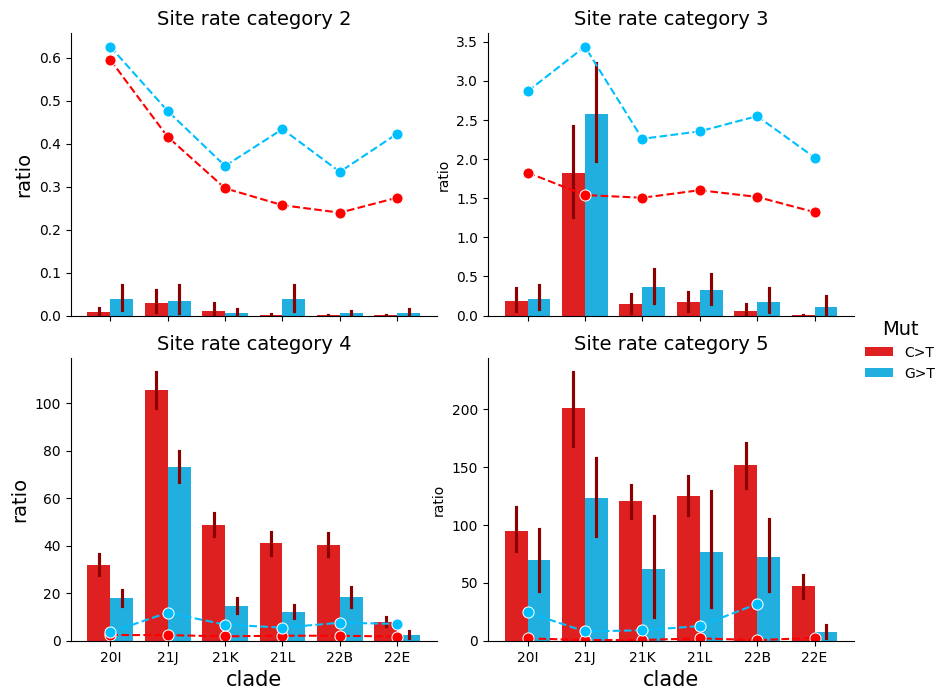

In [81]:
exp_ratios = hotspot_mut_ratio[['Mut', 'clade', 'rate_cat', 'expected_ratio']]\
    .drop_duplicates().rename(columns={'expected_ratio':'ratio'})

used_mutations = ['C>T', 'G>T']

g = sns.catplot(hotspot_mut_ratio, 
    sharey=False,
    col='rate_cat', 
    y='ratio', 
    hue='Mut', kind='bar', x='clade', col_wrap=2, 
    err_kws={'color':'darkred'}, aspect=1.25,
    palette=color_mapping12,
    hue_order=used_mutations,
    height=3.5,
)

g.set_titles("Site rate category {col_name}", size=14)
g.set_ylabels(size=14)
g.set_xlabels(size=15)
g.legend.get_title().set_fontsize(14)
g.legend.get_bbox_to_anchor()

for ax in g.axes.flat:
    cur_catt = int(ax.get_title()[-1])
    _ = exp_ratios.query('rate_cat == @cur_catt')
    sns.lineplot(_, x='clade', y='ratio', hue='Mut', ax=ax, legend=False,
                 palette=color_mapping12, linestyle='--', marker='o', markersize=8,
                 hue_order=used_mutations)


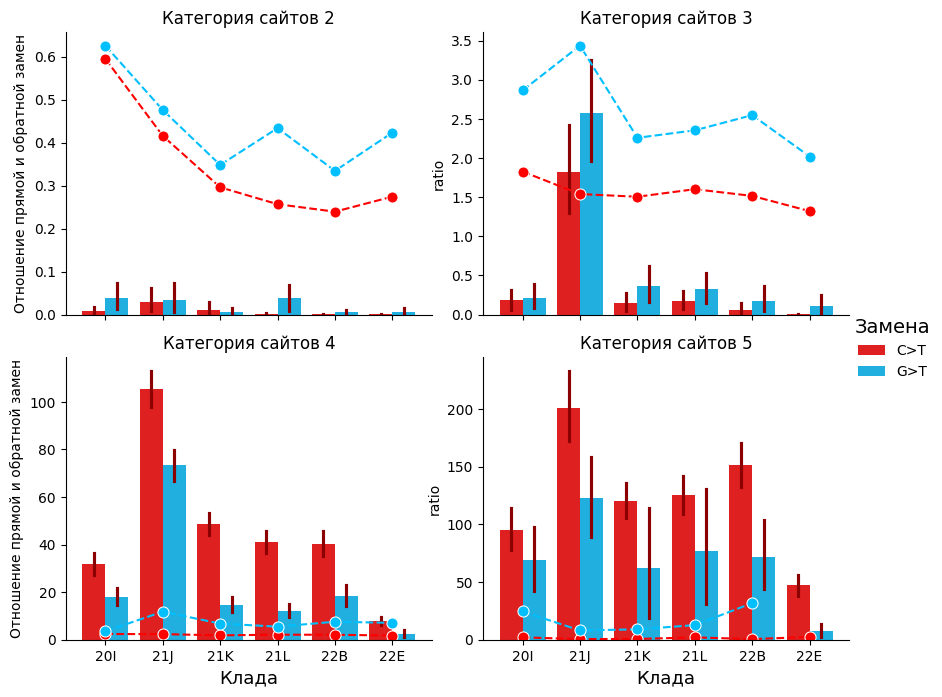

In [91]:
used_mutations = ['C>T', 'G>T']

g = sns.catplot(hotspot_mut_ratio, 
    sharey=False,
    col='rate_cat', 
    y='ratio', 
    hue='Mut', kind='bar', x='clade', col_wrap=2, 
    err_kws={'color':'darkred'}, aspect=1.25,
    palette=color_mapping12,
    hue_order=used_mutations,
    height=3.5,
)

g.set_titles("Категория сайтов {col_name}", size=12)
g.set_ylabels('Отношение прямой и обратной замен', size=10)
g.set_xlabels('Клада', size=13)
g.legend.set_title('Замена')
g.legend.get_title().set_fontsize(14)
g.legend.get_bbox_to_anchor()

for ax in g.axes.flat:
    cur_catt = int(ax.get_title()[-1])
    _ = exp_ratios.query('rate_cat == @cur_catt')
    sns.lineplot(_, x='clade', y='ratio', hue='Mut', ax=ax, legend=False,
                 palette=color_mapping12, linestyle='--', marker='o', markersize=8,
                 hue_order=used_mutations)

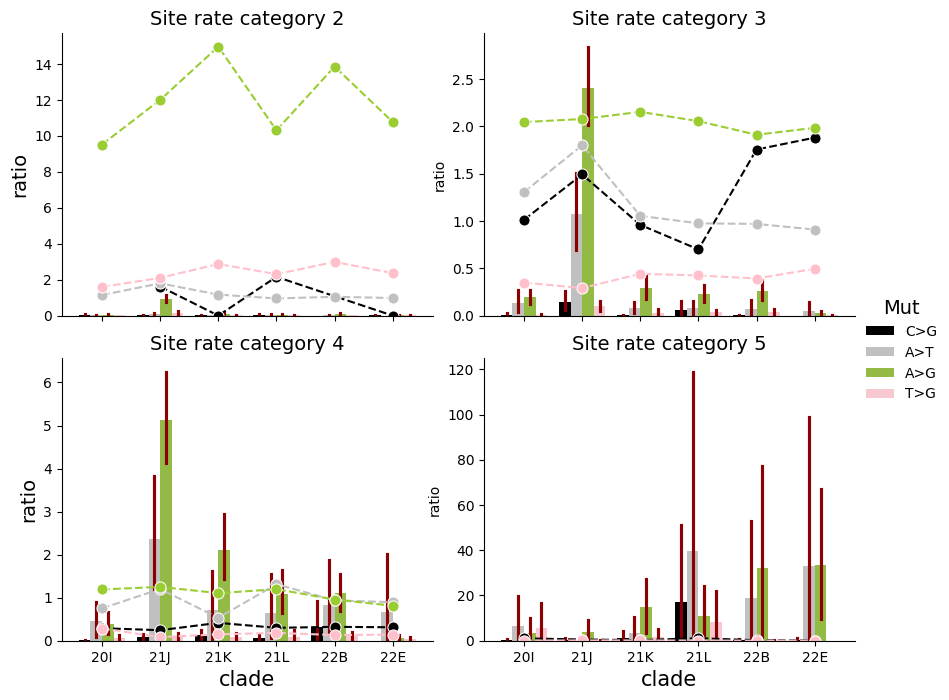

In [84]:
used_mutations = ['C>G', 'A>T', 'A>G', 'T>G']

g = sns.catplot(hotspot_mut_ratio,#.query('ratio > 0'), 
    sharey=False,
    col='rate_cat', 
    y='ratio', 
    hue='Mut', kind='bar', x='clade', col_wrap=2, 
    err_kws={'color':'darkred'}, aspect=1.25, height=3.5,
    palette=color_mapping12,
    hue_order=used_mutations,
)

g.set_titles("Site rate category {col_name}", size=14)
g.set_ylabels(size=14)
g.set_xlabels(size=15)
g.legend.get_title().set_fontsize(14)
g.legend.get_bbox_to_anchor()

for ax in g.axes.flat:
    cur_catt = int(ax.get_title()[-1])
    _ = exp_ratios.query('rate_cat == @cur_catt')
    sns.lineplot(_, x='clade', y='ratio', hue='Mut', ax=ax, legend=False,
                 palette=color_mapping12, linestyle='--', marker='o', markersize=8,
                 hue_order=used_mutations)

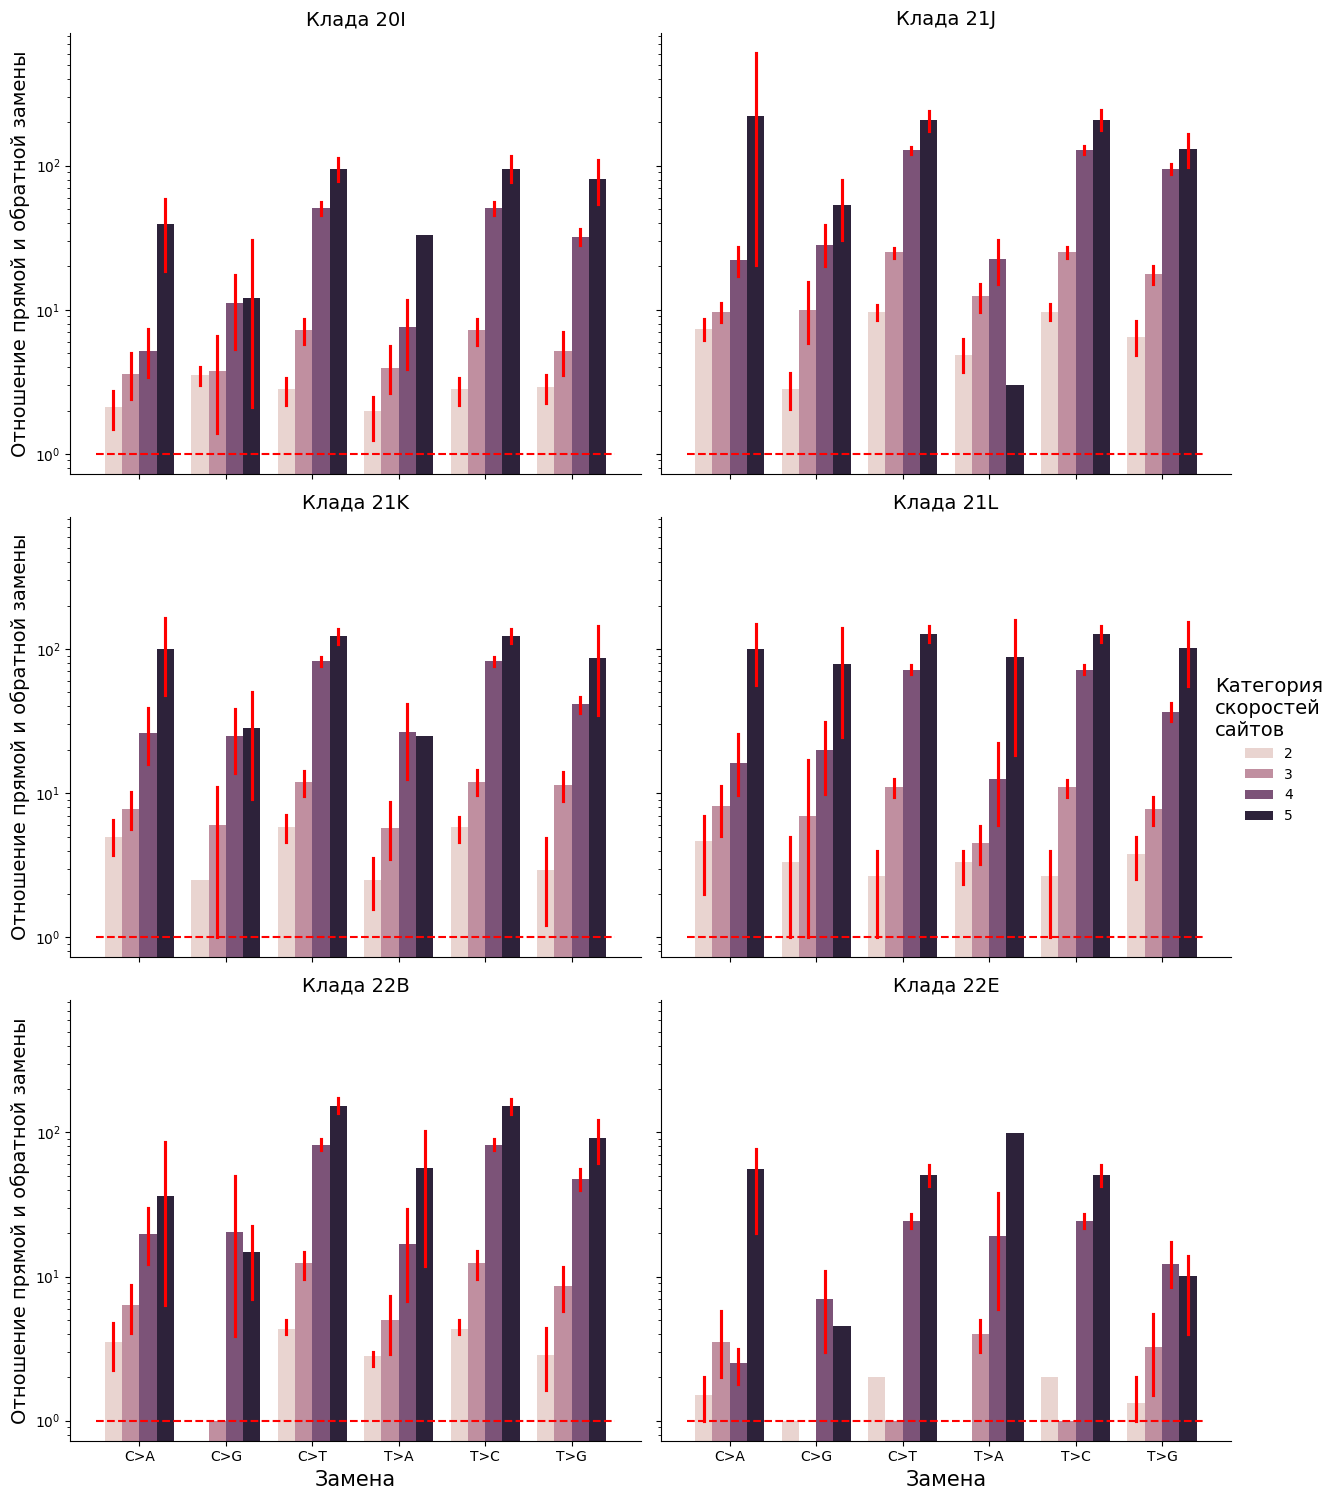

In [56]:
_ = hotspot_mut_ratio.copy()
_['Категория\nскоростей\nсайтов'] = _['rate_cat']
_['Отношение прямой и обратной замены'] = _['ratio']
_['Замена'] = _['Mut']
_['Клада'] = _['clade']
g = sns.catplot(_, sharey=True,
    hue='Категория\nскоростей\nсайтов', 
    y='Отношение прямой и обратной замены', 
    x='Замена', kind='bar', col='Клада', col_wrap=2, 
    err_kws={'color':'red'}, aspect=1.25,
)
g.set_titles("Клада {col_name}", size=14)
g.set_ylabels(size=14)
g.set_xlabels(size=15)
g.legend.get_title().set_fontsize(14)
g.legend.get_bbox_to_anchor()

for ax in g.axes.flat:
    ax.hlines(1, xmin=-0.5, xmax=5.5, colors='red', linestyles='--')
    ax.set_yscale('log')


### Fitting observed substitution spectra by site-specific rates

In [24]:
ref_sites_df.query('rate_cat == 1').head()

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
1    267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2    268   G     TGG       1  mat_peptide  ORF1ab          3           3   
129  395   C     TCA       1  mat_peptide  ORF1ab        130           1   
157  423   T     TTA       1  mat_peptide  ORF1ab        158           2   
265  531   T     GTA       1  mat_peptide  ORF1ab        266           2   

    Codon  MutCountTotal  ...  nt_site  codon_position aa_site   AA rate_cat  \
1     ATG            2.0  ...      267             2;2     1.0  Met        1   
2     ATG            1.0  ...      268             3;3     1.0  Met        1   
129   CAA           26.0  ...      395             1;1    44.0  Gln        1   
157   TTA           12.0  ...      423             2;2    53.0  Leu        1   
265   GTA           13.0  ...      531             2;2    89.0  Val        1   

     rate_cat_ns  fourfold  num_of_syn_codons  syn_codons syn_muts  
1              1     False                  0          {}       []  
2              1     False                  0          {}       []  
129            2     False                  0          {}       []  
157            2     False                  0          {}       []  
265            2      True                  0          {}       []  

[5 rows x 21 columns]

In [25]:
# cur_rate_cat = 'rate_cat'    # rate cats based on all mutations
cur_rate_cat = 'rate_cat_ns' # rate cats based on nonsynonymous mutations
mut_cnt_col = 'MutCountNonsyn' if cur_rate_cat == 'rate_cat_ns' else 'MutCountTotal'
print(cur_rate_cat)

# check 3 different approaches to get amino acid counts for normalization
def get_site_specific_aa_counts(df, site_cat):
    aa_counts = df.query(f'AA != "*" & {cur_rate_cat} == @site_cat').AA.value_counts().to_dict()
    return aa_counts

def get_uniform_aa_counts():
    return {x: 1 for x in amino_acid_codes.values()}
    
def get_original_aa_counts(df_obs):
    _orig_aa_cnt = df_obs.query('aa1 != "*"').groupby('aa1')['count'].sum()\
        .rename(index=amino_acid_codes).to_dict()
    return _orig_aa_cnt


metrics_total = []
d_to_eq_data = []
aa_subst_data = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_clade['rate'] /= spectrum_clade['rate'].sum()

    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    obs_clade = obs[obs['clade'] == clade]

    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    cur_ref_sites_df['Pos'] = cur_ref_sites_df['nt_site']
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df[mut_cnt_col], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df[cur_rate_cat] = categories

    for i, rcat in enumerate(cur_ref_sites_df[cur_rate_cat].unique()):
        cur_sites = cur_ref_sites_df.query(f'{cur_rate_cat} == @rcat').Pos.tolist()
        df_obs = obs_clade[obs_clade.nt_site.isin(cur_sites)]
        
        cur_aa_freqs_dct = get_site_specific_aa_counts(cur_ref_sites_df, rcat)
        # cur_aa_freqs_dct = get_original_aa_counts(df_obs)
        
        # Distance to equilibrium estimation
        _, cur_aa_freq = get_equilibrium_freqs(spectrum_clade, 'rate')
        cur_aa_freq['obs_cnt'] = cur_aa_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_freq['obs_freq'] = cur_aa_freq['obs_cnt'] / cur_aa_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])
        de = euclidean(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])

        d_to_eq_data.append({
            'clade': clade,
            'rcat': rcat,
            'cityblock': dm, 
            'euclidean': de, 
        })

        if len(df_obs) == 0:
            continue

        aa_subst = prepare_aa_subst(df_obs, exp_aa_subst, cur_aa_freqs_dct)
        aa_subst_data.append(aa_subst.assign(clade=clade, rate_cat=rcat))
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['nt_sites'] = df_obs.nt_site.nunique()
        cur_metrics['clade'] = clade
        cur_metrics['rate_cat'] = rcat
        metrics_total.append(cur_metrics)

    # for total sites set
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    # aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, get_uniform_aa_counts())
    aa_subst_data.append(aa_subst.assign(clade=clade, rate_cat='total'))
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['nt_sites'] = obs_clade.nt_site.nunique()
    cur_metrics['clade'] = clade
    cur_metrics['rate_cat'] = 'total'
    metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'rate_cat', 'nt_sites'])\
        .drop(['mape','wape','slope','intercept', 'ks_stat','ks_p','rmse','log_likelihood'], axis=1)
metrics_total_df.to_csv(f'data/fit_metrics_site_{cur_rate_cat}5.csv', float_format='%g')

d_to_eq_df = pd.DataFrame(d_to_eq_data)
d_to_eq_df['time_period'] = d_to_eq_df['clade'].map(_clade2label)
d_to_eq_df.to_csv(f'data/dist_to_eq_site_{cur_rate_cat}5.csv', float_format='%g', index=False)

aa_subst_df = pd.concat(aa_subst_data, ignore_index=True)
aa_subst_df.to_csv('data/aa_subst_total_rates.csv', float_format='%g', index=False)

rate_cat_ns


Clades: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


In [27]:
metrics_total_df['time_period'] = metrics_total_df.index.get_level_values(0).map(_clade2label)
metrics_total_df

r2  spearman_corr    spearman_p  pearson_corr  \
clade rate_cat nt_sites                                                        
20A   2        3569     -1.031232       0.649989  2.264510e-19      0.458869   
      1        4397     -1.654785       0.545259  5.413694e-13      0.341841   
      3        1807     -0.128910       0.717030  5.756521e-25      0.636439   
      4        2186      0.501483       0.709262  3.086392e-24      0.734471   
      5        124      -0.015122       0.472855  9.964670e-10      0.260552   
...                           ...            ...           ...           ...   
24A   3        1952     -0.439473       0.680685  9.507916e-22      0.579389   
      2        3502     -1.241423       0.615445  5.282154e-17      0.421665   
      1        3861     -1.716399       0.568990  3.041527e-14      0.314805   
      5        118      -0.020677       0.340292  2.037771e-05      0.199897   
      total    11685     0.662479       0.758251  2.748880e-29      0.823546   

                         pearson_corr_squared     pearson_p  mut_count  \
clade rate_cat nt_sites                                                  
20A   2        3569                  0.210561  3.513306e-09     8357.0   
      1        4397                  0.116855  1.857590e-05     4328.0   
      3        1807                  0.405055  2.086719e-18     8534.0   
      4        2186                  0.539448  1.072170e-26    35219.0   
      5        124                   0.067887  1.280969e-03     7993.0   
...                                       ...           ...        ...   
24A   3        1952                  0.335692  7.996510e-15     9348.0   
      2        3502                  0.177801  7.707210e-08     8334.0   
      1        3861                  0.099102  8.725748e-05     3824.0   
      5        118                   0.039959  1.418440e-02     9409.0   
      total    11685                 0.678228  2.868359e-38    64920.0   

                         mut_type_count  corr_chem_vs_rel_freq  \
clade rate_cat nt_sites                                          
20A   2        3569                 146              -0.106061   
      1        4397                 143              -0.127354   
      3        1807                 143              -0.050509   
      4        2186                 140              -0.062426   
      5        124                   91              -0.179518   
...                                 ...                    ...   
24A   3        1952                 146              -0.082447   
      2        3502                 144              -0.117092   
      1        3861                 139              -0.097933   
      5        118                   71              -0.150848   
      total    11685                150              -0.215114   

                         corr_chem_vs_rel_freq_pval              time_period  
clade rate_cat nt_sites                                                       
20A   2        3569                        0.196443             Early clades  
      1        4397                        0.120414             Early clades  
      3        1807                        0.539331             Early clades  
      4        2186                        0.447909             Early clades  
      5        124                         0.027939             Early clades  
...                                             ...                      ...  
24A   3        1952                        0.315846  Late clades\n(Omicron+)  
      2        3502                        0.153580  Late clades\n(Omicron+)  
      1        3861                        0.233156  Late clades\n(Omicron+)  
      5        118                         0.065386  Late clades\n(Omicron+)  
      total    11685                       0.008203  Late clades\n(Omicron+)  

[143 rows x 11 columns]

/tmp/ipykernel_65636/787834102.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _['rate_cat'] = _['rate_cat'].replace('total', 6)


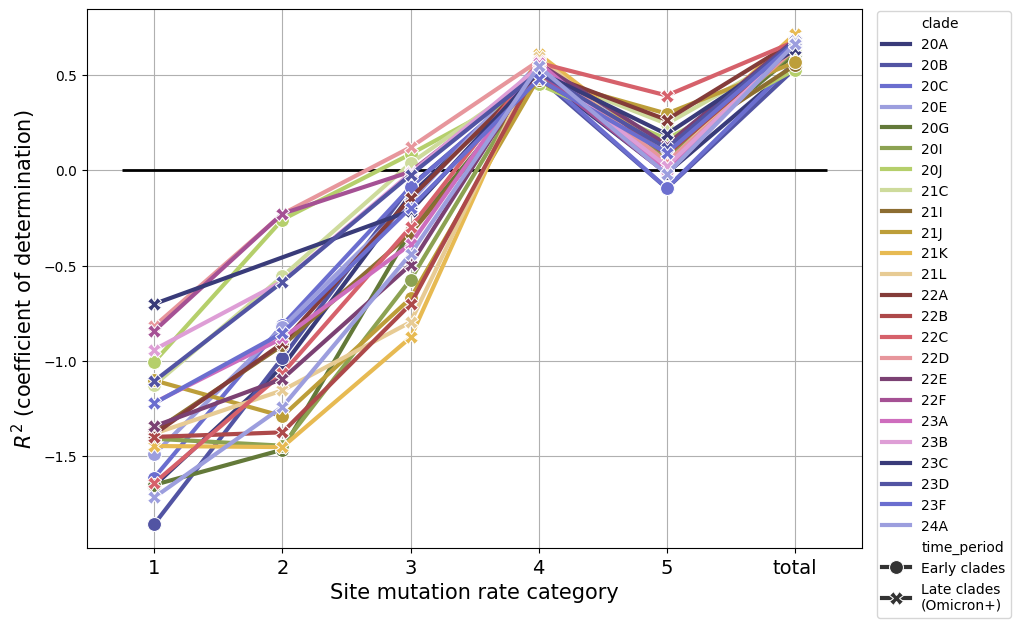

In [ ]:
_ = metrics_total_df.reset_index()
_['rate_cat'] = _['rate_cat'].replace('total', 6) 

plt.figure(figsize=(10, 7))
ax = sns.lineplot(
    _, x='rate_cat', y='r2', hue='clade', style='time_period', 
    markers=True, dashes=False, palette='tab20b', 
    linewidth=3, markersize=10,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(1, 7), ['1', '2', '3', '4', '5', 'total'])
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)
bou = ax.get_xbound()
ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.xticks(fontsize=14)
plt.show()

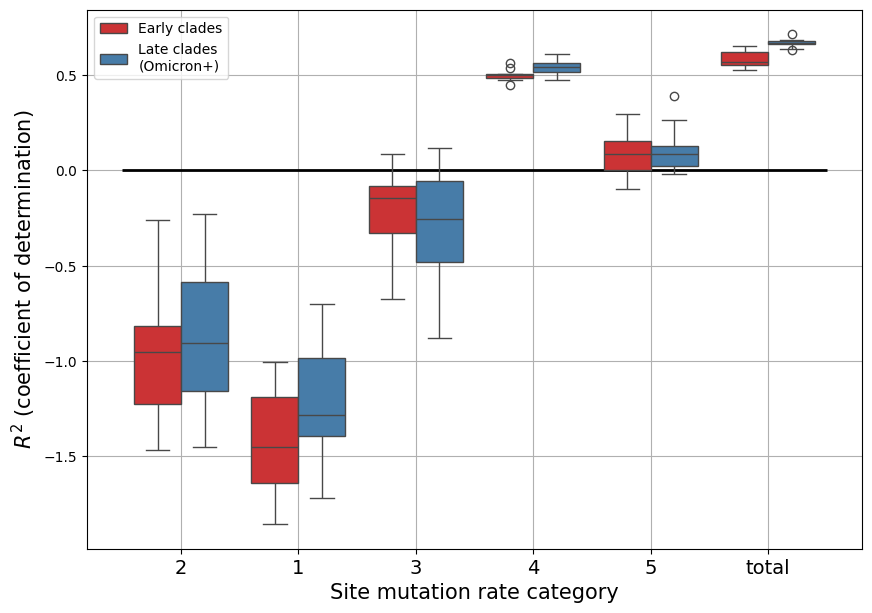

In [109]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(
    metrics_total_df, x='rate_cat', y='r2', hue='time_period', 
    palette='Set1', 
    # linewidth=1,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)
bou = ax.get_xbound()
ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)

plt.legend(loc='upper left')
plt.xticks(fontsize=14)
plt.show()

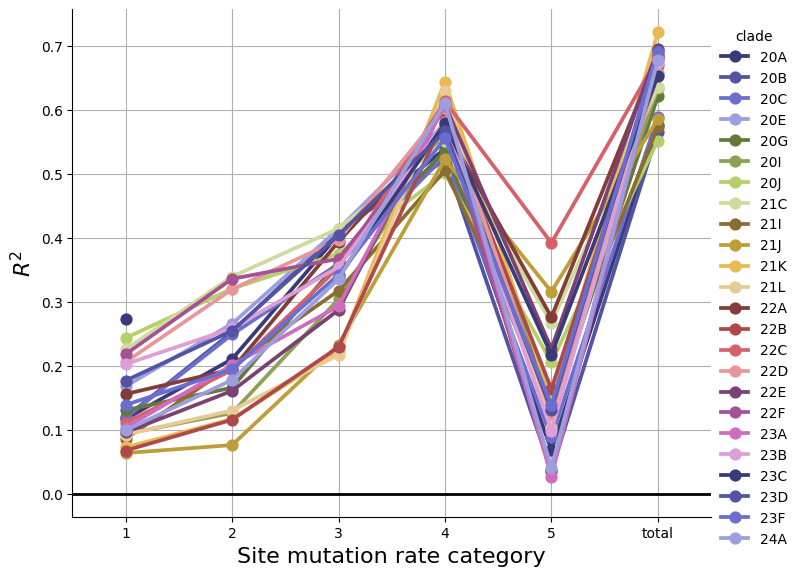

In [ ]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat'], ['pearson_corr_squared', ])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    kind='point', height=6, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title('')
    ax.set_ylabel('$R^2$', fontsize=16)
    ax.set_xlabel('Site mutation rate category', fontsize=16)
    bou = ax.get_xbound()
    ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.set_xlim(bou)

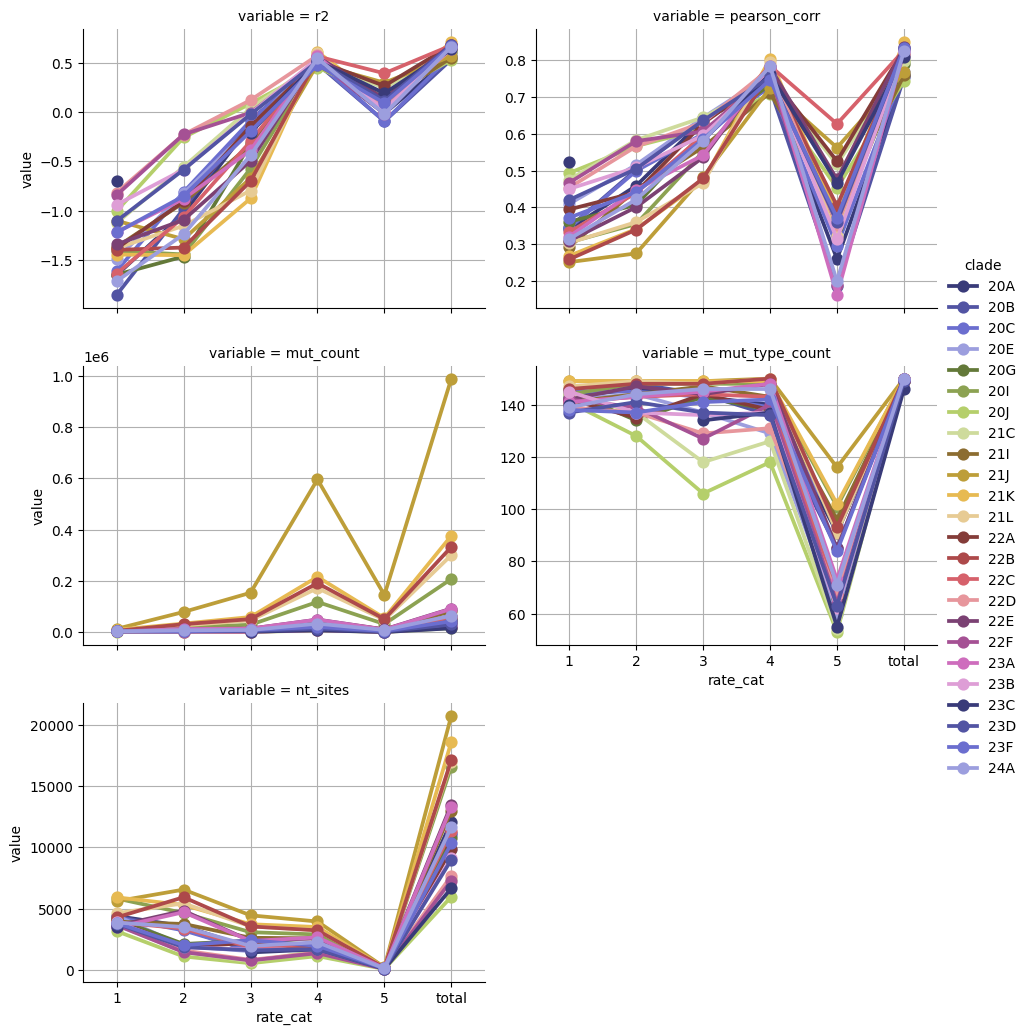

In [84]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat'], ['r2', 'pearson_corr', 'mut_count', 'mut_type_count','nt_sites'])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    col_wrap=2, kind='point', height=4, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)

# g.axes_dict['mut_count'].set_ylim(0, 200000)

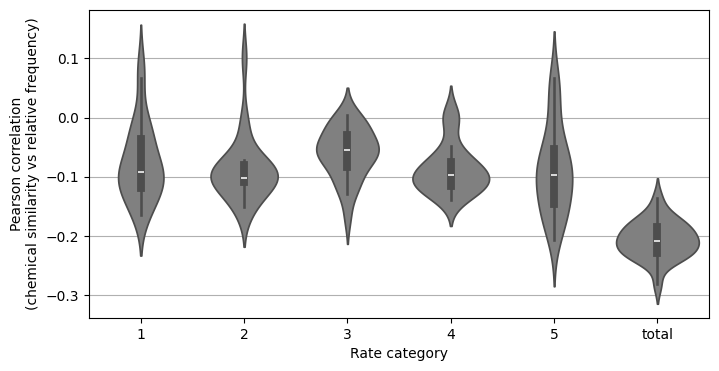

In [86]:
plt.figure(figsize=(8, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index(), 
    x='rate_cat', y='corr_chem_vs_rel_freq', color='gray',
    order=[1,2,3,4,5,'total'])
plt.ylabel('Pearson correlation\n(chemical similarity vs relative frequency)',)
plt.xlabel('Rate category')
ax.set_axisbelow(True)
plt.grid(True, axis='y')

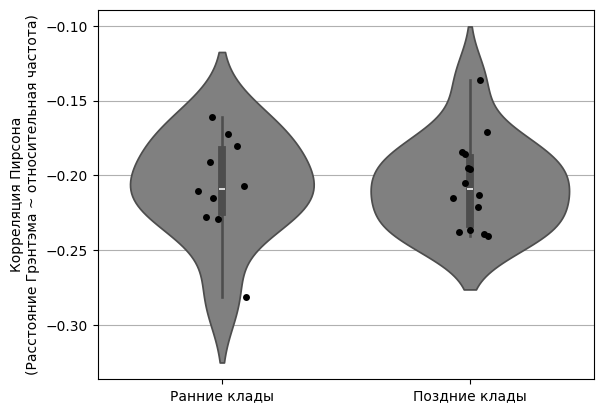

In [47]:
# plt.figure(figsize=(4, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index().query('rate_cat == "total"'), 
    x='time_period', y='corr_chem_vs_rel_freq', color='gray',
)
ax=sns.stripplot(
    data=metrics_total_df.reset_index().query('rate_cat == "total"'), 
    x='time_period', y='corr_chem_vs_rel_freq', color='k',
)
plt.xlabel('')
plt.xticks([0, 1], ['Ранние клады', 'Поздние клады'])
plt.ylabel('Корреляция Пирсона\n(Расстояние Грэнтэма ~ относительная частота)',)
plt.grid(True, axis='y')
ax.set_axisbelow(True)

/tmp/ipykernel_38126/1378842234.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  ax=sns.violinplot(


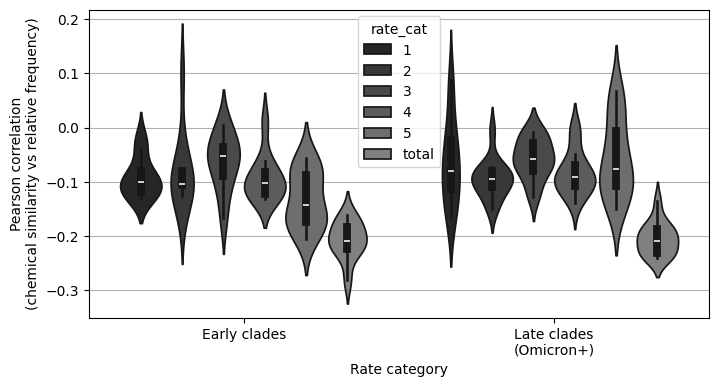

In [ ]:
# no difference between early and late clades
plt.figure(figsize=(8, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index(), 
    hue='rate_cat', y='corr_chem_vs_rel_freq', x='time_period',
    color='gray', hue_order=[1,2,3,4,5,'total'])
plt.ylabel('Pearson correlation\n(chemical similarity vs relative frequency)',)
plt.xlabel('Rate category')
ax.set_axisbelow(True)
plt.grid(True, axis='y')

In [ ]:
metrics_total_df.query('corr_chem_vs_rel_freq_pval < 0.05').reset_index().rate_cat.value_counts()

rate_cat
total    23
5         4
2         1
3         1
1         1
Name: count, dtype: int64

### NEW Fitting observed substitution spectra by site-specific rates (spectra are clade- and rate_cat- specific)

In [36]:
cur_rate_cat = 'rate_cat'    # rate cats based on all mutations
# cur_rate_cat = 'rate_cat_ns' # rate cats based on nonsynonymous mutations
mut_cnt_col = 'MutCountNonsyn' if cur_rate_cat == 'rate_cat_ns' else 'MutCountTotal'
print(cur_rate_cat)

# check 3 different approaches to get amino acid counts for normalization
def get_site_specific_aa_counts(df, site_cat):
    aa_counts = df.query(f'AA != "*" & {cur_rate_cat} == @site_cat').AA.value_counts().to_dict()
    return aa_counts

def get_uniform_aa_counts():
    return {x: 1 for x in amino_acid_codes.values()}
    
def get_original_aa_counts(df_obs):
    _orig_aa_cnt = df_obs.query('aa1 != "*"').groupby('aa1')['count'].sum()\
        .rename(index=amino_acid_codes).to_dict()
    return _orig_aa_cnt


metrics_total = []
d_to_eq_data = []
aa_subst_total = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    obs_clade = obs[obs['clade'] == clade]

    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    cur_ref_sites_df['Pos'] = cur_ref_sites_df['nt_site']
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df[mut_cnt_col], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df[cur_rate_cat] = categories

    for i, rcat in enumerate(cur_ref_sites_df[cur_rate_cat].unique()):
        cur_ms = cat_spectra.loc[(clade, rcat)].rename('rate').replace([np.inf], np.nan).fillna(0).reset_index()
        cur_ms['rate'] += 1e-10  # to avoid zero rates
        exp_aa_subst, _ = prepare_exp_aa_subst(cur_ms, 'rate', 1)

        cur_sites = cur_ref_sites_df.query(f'{cur_rate_cat} == @rcat').Pos.tolist()
        df_obs = obs_clade[obs_clade.nt_site.isin(cur_sites)]
        
        cur_aa_freqs_dct = get_site_specific_aa_counts(cur_ref_sites_df, rcat)
        # cur_aa_freqs_dct = get_original_aa_counts(df_obs)
        
        # Distance to equilibrium estimation
        _, cur_aa_freq = get_equilibrium_freqs(cur_ms, 'rate')
        cur_aa_freq['obs_cnt'] = cur_aa_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_freq['obs_freq'] = cur_aa_freq['obs_cnt'] / cur_aa_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])
        de = euclidean(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])

        d_to_eq_data.append({
            'clade': clade,
            'rcat': rcat,
            'cityblock': dm, 
            'euclidean': de, 
        })

        if len(df_obs) == 0:
            continue

        aa_subst = prepare_aa_subst(df_obs, exp_aa_subst, cur_aa_freqs_dct)
        aa_subst_total.append(aa_subst.assign(clade=clade, rate_cat=rcat))
        
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['nt_sites'] = df_obs.nt_site.nunique()
        cur_metrics['clade'] = clade
        cur_metrics['rate_cat'] = rcat
        metrics_total.append(cur_metrics)

    # for total sites set
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_clade['rate'] /= spectrum_clade['rate'].sum()
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    aa_subst_total.append(aa_subst.assign(clade=clade, rate_cat='total'))

    # aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, get_uniform_aa_counts())
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['nt_sites'] = obs_clade.nt_site.nunique()
    cur_metrics['clade'] = clade
    cur_metrics['rate_cat'] = 'total'
    metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'rate_cat', 'nt_sites'])\
        .drop(['mape','wape','slope','intercept', 'ks_stat','ks_p','rmse','log_likelihood'], axis=1)
metrics_total_df.to_csv(f'data/fit_metrics_site_{cur_rate_cat}5_new.csv', float_format='%g')

d_to_eq_df = pd.DataFrame(d_to_eq_data)
d_to_eq_df['time_period'] = d_to_eq_df['clade'].map(_clade2label)
d_to_eq_df.to_csv(f'data/dist_to_eq_site_{cur_rate_cat}5_new.csv', float_format='%g', index=False)

rate_cat


Clades: 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


In [37]:
aa_subst_total_df = pd.concat(aa_subst_total, ignore_index=True)
aa_subst_total_df.to_csv('data/aa_subst_total_rates_cat_spec.csv', float_format='%g')


In [38]:
metrics_total_df['time_period'] = metrics_total_df.index.get_level_values(0).map(_clade2label)
metrics_total_df

r2  spearman_corr    spearman_p  pearson_corr  \
clade rate_cat nt_sites                                                        
20A   2        3658     -0.283097       0.494831  1.222426e-10      0.492283   
      1        3804     -7.397009       0.410828  1.770763e-07      0.313816   
      4        2143      0.407836       0.673751  3.466776e-21      0.640704   
      3        2360      0.374231       0.687596  2.526332e-22      0.680989   
      5        118      -0.083913       0.328342  4.095431e-05      0.155202   
...                           ...            ...           ...           ...   
24A   3        2015      0.260006       0.682997  6.127386e-22      0.598883   
      2        4377     -0.792598       0.524427  5.662480e-12      0.449996   
      1        3185     -1.777460       0.438218  2.041730e-08      0.436892   
      5        98       -0.068770       0.286283  3.829965e-04      0.126218   
      total    11685     0.662479       0.758251  2.748880e-29      0.823546   

                         pearson_corr_squared     pearson_p  mut_count  \
clade rate_cat nt_sites                                                  
20A   2        3658                  0.242342  1.571215e-10     8126.0   
      1        3804                  0.098481  9.208642e-05     3749.0   
      4        2143                  0.410501  1.049786e-18    34987.0   
      3        2360                  0.463746  8.975149e-22    10747.0   
      5        118                   0.024088  5.790200e-02     6822.0   
...                                       ...           ...        ...   
24A   3        2015                  0.358661  5.730729e-16    10836.0   
      2        4377                  0.202496  7.591799e-09    11174.0   
      1        3185                  0.190875  2.276976e-08     3162.0   
      5        98                    0.015931  1.237846e-01     7229.0   
      total    11685                 0.678228  2.868359e-38    64920.0   

                         mut_type_count  corr_chem_vs_rel_freq  \
clade rate_cat nt_sites                                          
20A   2        3658                 147              -0.059858   
      1        3804                 143               0.025027   
      4        2143                 139              -0.139411   
      3        2360                 145              -0.024665   
      5        118                   88              -0.110417   
...                                 ...                    ...   
24A   3        2015                 145               0.027771   
      2        4377                 145              -0.149909   
      1        3185                 139               0.026031   
      5        98                    67              -0.099470   
      total    11685                150              -0.215114   

                         corr_chem_vs_rel_freq_pval              time_period  
clade rate_cat nt_sites                                                       
20A   2        3658                        0.466839             Early clades  
      1        3804                        0.761127             Early clades  
      4        2143                        0.088855             Early clades  
      3        2360                        0.764480             Early clades  
      5        118                         0.178584             Early clades  
...                                             ...                      ...  
24A   3        2015                        0.735858  Late clades\n(Omicron+)  
      2        4377                        0.067100  Late clades\n(Omicron+)  
      1        3185                        0.751853  Late clades\n(Omicron+)  
      5        98                          0.225870  Late clades\n(Omicron+)  
      total    11685                       0.008203  Late clades\n(Omicron+)  

[143 rows x 11 columns]

/tmp/ipykernel_46110/2626833261.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _['rate_cat'] = _['rate_cat'].replace('total', 6)


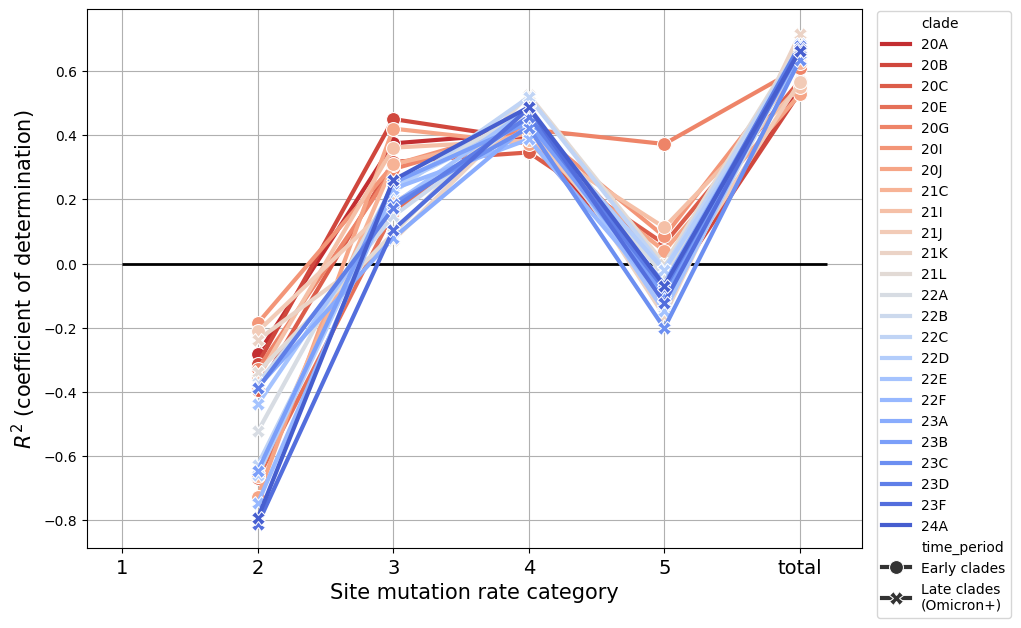

In [45]:
_ = metrics_total_df.reset_index().query('rate_cat != 0')
_['rate_cat'] = _['rate_cat'].replace('total', 6) 

plt.figure(figsize=(10, 7))
ax = sns.lineplot(
    _.query('rate_cat > 1'), x='rate_cat', y='r2', hue='clade', style='time_period', 
    markers=True, dashes=False, palette='coolwarm_r', 
    linewidth=3, markersize=10,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(1, 7), ['1', '2', '3', '4', '5', 'total'])
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)
bou = ax.get_xbound()
ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.xticks(fontsize=14)
plt.show()

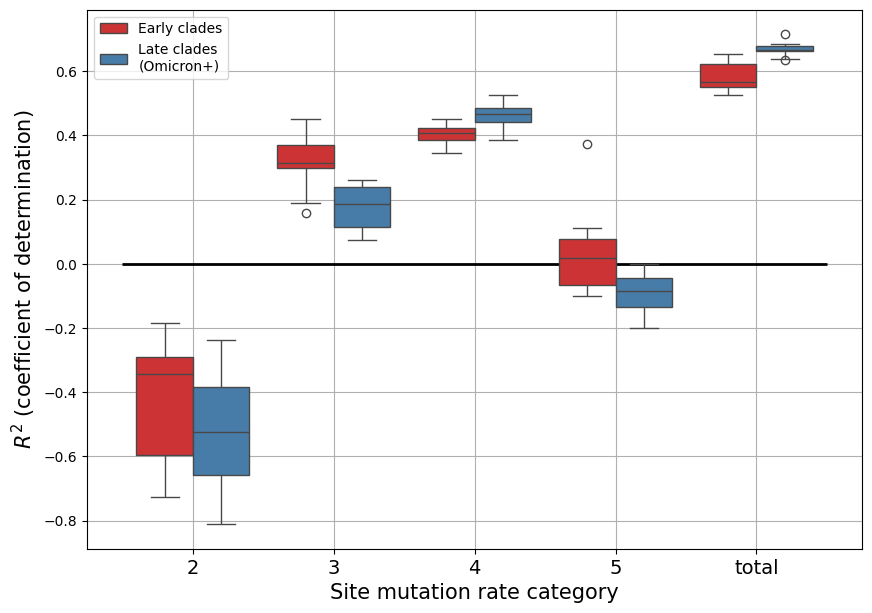

In [40]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(
    metrics_total_df.query('rate_cat != 1'), x='rate_cat', y='r2', hue='time_period', 
    palette='Set1', 
    order=[2,3,4,5,'total'],
    # linewidth=1,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)
bou = ax.get_xbound()
ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)

plt.legend(loc='upper left')
plt.xticks(fontsize=14)
plt.show()

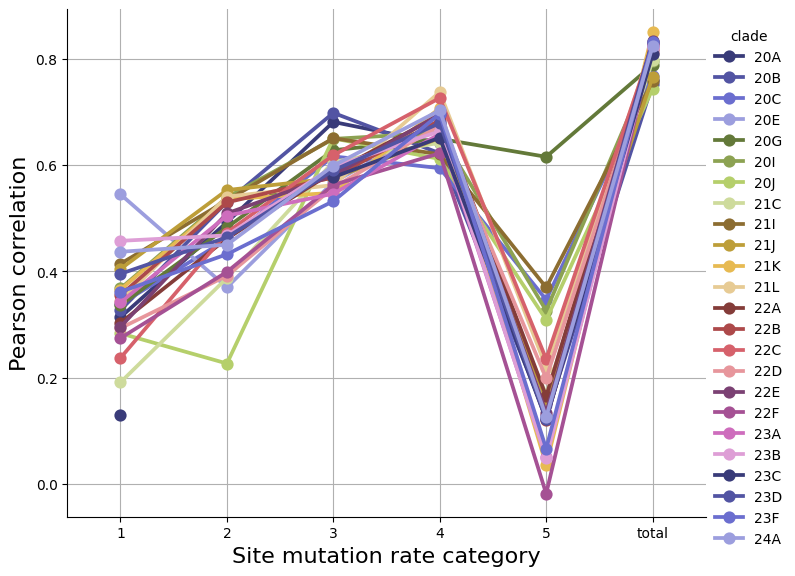

In [41]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat'], ['pearson_corr', ])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    kind='point', height=6, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title('')
    ax.set_ylabel('Pearson correlation', fontsize=16)
    ax.set_xlabel('Site mutation rate category', fontsize=16)
    bou = ax.get_xbound()
    # ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.set_xlim(bou)

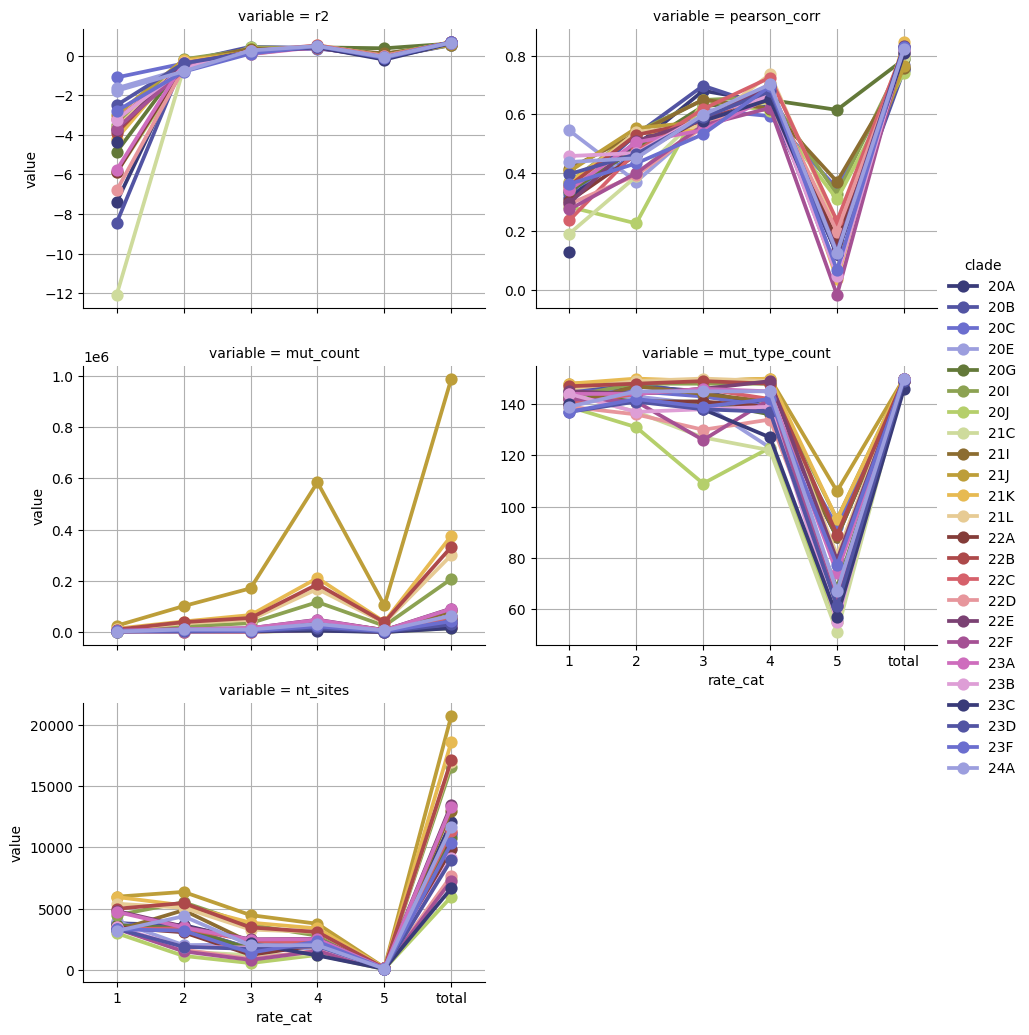

In [46]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat'], ['r2', 'pearson_corr', 'mut_count', 'mut_type_count','nt_sites'])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    col_wrap=2, kind='point', height=4, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)

# g.axes_dict['mut_count'].set_ylim(0, 200000)

### Distance to equilibrium VIZ

In [123]:
d_to_eq_df

clade  rcat  cityblock  euclidean              time_period
0     20A     2   0.833101   0.216444             Early clades
1     20A     1   1.202285   0.346064             Early clades
2     20A     4   0.710054   0.218921             Early clades
3     20A     3   0.528288   0.144085             Early clades
4     20A     5   1.375346   0.428586             Early clades
..    ...   ...        ...        ...                      ...
114   24A     4   0.590361   0.184017  Late clades\n(Omicron+)
115   24A     3   0.347773   0.092658  Late clades\n(Omicron+)
116   24A     2   0.859704   0.237503  Late clades\n(Omicron+)
117   24A     1   1.564142   0.454876  Late clades\n(Omicron+)
118   24A     5   1.463686   0.503294  Late clades\n(Omicron+)

[119 rows x 5 columns]

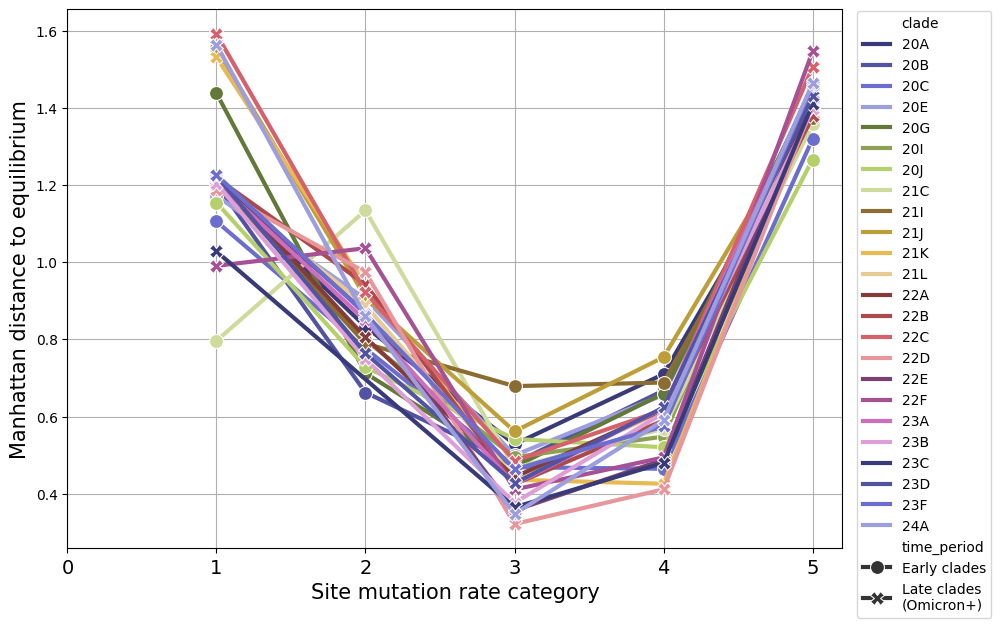

In [124]:
plt.figure(figsize=(10, 7))
ax = sns.lineplot(
    d_to_eq_df, x='rcat', y='cityblock', hue='clade', style='time_period', 
    markers=True, dashes=False, palette='tab20b', 
    linewidth=3, markersize=10, 
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(6))
ax.set_ylabel('Manhattan distance to equilibrium', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

### Calculate aa content of most variable and constant sites

In [88]:
# add indexes to amino acids
naa = ref_sites_df.query('AA != "*"').shape[0] // 3
aa_indexes = np.repeat(np.arange(naa), 3)+1
ref_sites_df['aa_index'] = -1
ref_sites_df.loc[(ref_sites_df['AA'] != "*"), 'aa_index'] = aa_indexes

In [89]:
ref_sites_df.tail(3100).head(10)

Pos Nuc Context  Strand Type gene  PosInGene  PosInCodon Codon  \
26160  26465   T     CTG       1  CDS    E        221           2   CTG   
26161  26466   G     TGG       1  CDS    E        222           3   CTG   
26162  26467   G     GGT       1  CDS    E        223           1   GTC   
26163  26468   T     GTC       1  CDS    E        224           2   GTC   
26164  26469   C     TCT       1  CDS    E        225           3   GTC   
26165  26470   T     CTA       1  CDS    E        226           1   TAA   
26166  26471   A     TAA       1  CDS    E        227           2   TAA   
26167  26472   A     AAA       1  CDS    E        228           3   TAA   
26168  26523   A     CAT       1  CDS    M          1           1   ATG   
26169  26524   T     ATG       1  CDS    M          2           2   ATG   

       MutCountTotal  MutCountNonsyn  nt_site codon_position  rate_cat  \
26160           57.0            57.0  26465.0              2         2   
26161          161.0             0.0      NaN            NaN         3   
26162          929.0           929.0  26467.0              1         4   
26163           35.0            35.0  26468.0              2         2   
26164          370.0             0.0      NaN            NaN         4   
26165            2.0             0.0      NaN            NaN         1   
26166            8.0             0.0      NaN            NaN         1   
26167           11.0             0.0      NaN            NaN         1   
26168            6.0             6.0  26523.0              1         1   
26169            5.0             5.0  26524.0              2         1   

       rate_cat_ns   AA  aa_index  
26160            3  Leu      8546  
26161            0  Leu      8546  
26162            4  Val      8547  
26163            2  Val      8547  
26164            0  Val      8547  
26165            0    *        -1  
26166            0    *        -1  
26167            0    *        -1  
26168            1  Met      8548  
26169            1  Met      8548

In [90]:
aa_mutability = ref_sites_df.query('AA != "*"').groupby(['aa_index', 'AA'])['MutCountNonsyn'].sum()
aa_mutability = aa_mutability.sort_values()

n = 2000 # number of sites to consider as most variable or most constant
constant_sites_aa_content = aa_mutability.head(n).reset_index()['AA'].value_counts().to_dict()
variable_sites_aa_content = aa_mutability.tail(n).reset_index()['AA'].value_counts().to_dict()

In [91]:
_, cur_aa_freq = get_equilibrium_freqs(spectrum_20A, 'rate')
cur_aa_freq['var_sites'] = cur_aa_freq['aa'].map(variable_sites_aa_content)
cur_aa_freq['const_sites'] = cur_aa_freq['aa'].map(constant_sites_aa_content)
cur_aa_freq['var_freq'] = cur_aa_freq['var_sites'] / cur_aa_freq['var_sites'].sum()
cur_aa_freq['const_freq'] = cur_aa_freq['const_sites'] / cur_aa_freq['const_sites'].sum()
cur_aa_freq

aa   eq_freq  var_sites  const_sites  var_freq  const_freq
0   Phe  0.314637         16          159    0.0080      0.0795
1   Leu  0.197825        211          354    0.1055      0.1770
2   Ser  0.119281        180          130    0.0900      0.0650
3   Ile  0.086898         63           98    0.0315      0.0490
4   Tyr  0.073639         22          158    0.0110      0.0790
5   Val  0.044165        121          103    0.0605      0.0515
6   Cys  0.035283         38          121    0.0190      0.0605
7   Thr  0.025257        262           85    0.1310      0.0425
8   His  0.020183         76           52    0.0380      0.0260
9   Pro  0.017862        150           55    0.0750      0.0275
10  Asn  0.017199         25          105    0.0125      0.0525
11  Arg  0.009142         99           65    0.0495      0.0325
12  Asp  0.008012         84           54    0.0420      0.0270
13  Ala  0.007127        256           57    0.1280      0.0285
14  Met  0.006878         65           34    0.0325      0.0170
15  Gln  0.005073         79           83    0.0395      0.0415
16  Lys  0.004677         62           54    0.0310      0.0270
17  Gly  0.002844        114          144    0.0570      0.0720
18  Glu  0.002015         58           47    0.0290      0.0235
19  Trp  0.002004         19           42    0.0095      0.0210

In [92]:
cur_aa_freq.sort_values('eq_freq').tail().sum()

aa             TyrIleSerLeuPhe
eq_freq               0.792281
var_sites                  492
const_sites                899
var_freq                 0.246
const_freq              0.4495
dtype: object

In [93]:
d_var = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['var_freq'])
d_const = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['const_freq'])
print(d_var, d_const)

1.1345236738029898 0.696283075519111
